<a href="https://colab.research.google.com/github/FrancescoManca-FM/Project_MLDL/blob/main/Copia_di_Copia_di_LWF_funzionante.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GPU

In [1]:
# Check GPU assigned
!nvidia-smi

Sun Jul 11 14:35:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    25W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Network, dataset, functions and parameters

### LIBRARIES

In [2]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms

from PIL import Image
from tqdm import tqdm
import random


import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix

### Resnet32

In [3]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo

"""
Credits to @hshustc
Taken from https://github.com/hshustc/CVPR19_Incremental_Learning/tree/master/cifar100-class-incremental
"""

import math
from torch.nn import init
import torch
import torch.nn as nn

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.stride = stride
        self.use_relu = use_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.use_relu:
            out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Downsample(nn.Module):
    def __init__(self, nIn, nOut, stride):
        super(Downsample, self).__init__()
        assert stride == 2
        self.avg = nn.AvgPool2d(kernel_size=1, stride=stride)

    def forward(self, x):
        x = self.avg(x)
        return torch.cat((x, x.mul(0)), 1)


class CifarResNet(nn.Module):

    def __init__(self, block=BasicBlock, depth=32, num_classes=0, channels=3):

        super(CifarResNet, self).__init__()

        # Model type specifies number of layers for CIFAR-10 and CIFAR-100 model
        assert (depth - 2) % 6 == 0, 'depth should be one of 20, 32, 44, 56, 110'
        layer_blocks = (depth - 2) // 6
        bn = nn.BatchNorm2d
        self.inplanes = 16

        self.conv_1_3x3 = nn.Conv2d(channels, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_1 = bn(self.inplanes)

        self.stage_1 = self._make_layer(block, 16, layer_blocks, 1)
        self.stage_2 = self._make_layer(block, 32, layer_blocks, 2)
        self.stage_3 = self._make_layer(block, 64, layer_blocks, 2, last=True)
        self.avgpool = nn.AvgPool2d(8)
        self.relu = nn.ReLU()
        #self.linear = nn.Linear(64, num_classes)
        self.fcs = nn.ModuleList([nn.Linear(64, num_classes)])

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, math.sqrt(1. / 64.))
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, last=False):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = Downsample(self.
inplanes, planes * block.expansion, stride)

        layers = [block(self.inplanes, planes, stride, downsample)]

        self.inplanes = planes * block.expansion

        if last:
            for i in range(1, blocks - 1):
                layers.append(block(self.inplanes, planes))

            layers.append(block(self.inplanes, planes, use_relu=False))

        else:
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv_1_3x3(x)

        x = self.bn_1(x)
        x = self.relu(x)

        x = self.stage_1(x)
        x = self.stage_2(x)
        x = self.stage_3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        return x

    def predict(self, x):
        out = []
        for fc in self.fcs:
            out.append(fc(x))
        out = torch.cat(out, dim=1)
        return out

    def addOutputNodes(self, num_classes):
        self.fcs.append(nn.Linear(64, num_classes))

### Cifar100

In [4]:
# ref:
# https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py
# https://pytorch.org/docs/stable/_modules/torchvision/datasets/cifar.html#CIFAR10
# homework2 (caltech)

from torchvision.datasets import VisionDataset
from PIL import Image

import os
import os.path
import numpy as np
import pandas as pd
import pickle
import random

from torch.autograd import Variable

# This is an handler class for the Cifar dataset
class CIFAR100(VisionDataset):
    """
    `CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    This is a subclass of the `CIFAR100` Dataset.
    """
    base_folder = 'cifar-100-python'
    train_file = 'train'
    test_file = 'test'
    meta_file = 'meta'

    def __init__(self, root, split = 'train', transform = None):
        """
          Args:
              root (string): Root directory of the dataset where directory
                  cifar-100-python exists.
              split (string, optional): If 'train', creates dataset from training
                  set, otherwise creates from test set.
              transform (callable, optional): A function/transform that takes in a
                  PIL image and returns a transformed version.
        """
        super(CIFAR100, self).__init__(root, transform=transform)

        self.split = split
        if split == 'train':
            filename = self.train_file
        else:
            filename = self.test_file

        data_path = os.path.join(self.root, self.base_folder, filename)
        data = None
        labels = None

        with open(data_path, 'rb') as f:
            entry = pickle.load(f, encoding='latin1')
            data = entry['data']
            labels = entry['fine_labels']
        
        data = np.vstack(data).reshape(-1, 3, 32, 32)
        data = data.transpose((0, 2, 3, 1))  # Convert to HWC
        
        labels = np.array(labels)

        self.df = pd.DataFrame()
        self.df['data'] = pd.Series(list(data))
        self.df['labels'] = labels

        self.data = self.df['data']
        self.labels = self.df['labels']

        self._load_meta()

    def _load_meta(self):
        meta_path = os.path.join(self.root, self.base_folder, self.meta_file)
        with open(meta_path, 'rb') as f:
            meta = pickle.load(f, encoding='latin1')
            self.label_names = meta['fine_label_names']

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.df.loc[index, 'data'], self.df.loc[index, 'labels']

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img) # Return a PIL image

        if self.transform is not None:
            img = self.transform(img)

        return index, img, target
    def __len__(self):
        return len(self.data)


    def getTargets(self):
        return set(self.labels)
     
    # test
    def get_indices(self, labels):
        return list(self.df[self.df['labels'].isin(labels)].index)

    def split_classes(self, n_splits=10, seed=None, dictionary_of='dataframes'):
        if dictionary_of not in ['dataframes','indices']:
            raise ValueError("'dictionary_of' must be equal to 'dataframes' or 'indices'")

        all_classes = list(self.df['labels'].value_counts().index)
        dictionary = {}
        random.seed(seed)
        random.shuffle(all_classes)
        split_size = int(len(all_classes)/n_splits)
        for j in range(n_splits):
            if ((j+1)*split_size < len(all_classes)):
                split_end = (j+1)*split_size
            else:
                split_end = None
            subgroup = all_classes[j*split_size:split_end]
            if dictionary_of == 'dataframes':
                dictionary[j] = self.df[self.df['labels'].isin(subgroup)]
            elif dictionary_of == 'indices':
                dictionary[j] = list(self.df[self.df['labels'].isin(subgroup)].index)
        return dictionary

    def split_groups_in_train_validation(self, groups, ratio=0.5, seed=None):
        groups_train_val = dict()
        for k, subdf in groups.items():
            train_indexes = []
            val_indexes = []
            split_labels = list(subdf['labels'].value_counts().index)
            for l in split_labels:
                indexes_to_sample = list(subdf[subdf['labels'] == l].index)
                random.seed(seed)
                train_samples = random.sample(indexes_to_sample, int(len(indexes_to_sample)*ratio))
                train_indexes = train_indexes + train_samples
                val_indexes = val_indexes + list(set(indexes_to_sample).difference(set(train_samples)))
            groups_train_val[k] = {
                'train': train_indexes,
                'val': val_indexes
            }
        return groups_train_val
    
    def split_in_train_val_groups(self, n_splits=10, ratio=0.5, seed=None):
        groups = self.split_classes(n_splits=n_splits, seed=seed)
        return self.split_groups_in_train_validation(groups, ratio=ratio, seed=seed)

    # given a tensors returns an image (used in exemplars)
    #def tensorToImg(self, tensor):
    #   return Variable(transform(Image.fromarray(img)), volatile=True)


### Reverse Index

In [5]:
import pandas as pd
import numpy as np
import torch

__all__ = ['ReverseIndex']

class ReverseIndex():

    def __init__(self, dataset, splits, device='cuda'):

        self.df = pd.DataFrame(columns=['group', 'labels'])

        for k in splits.keys():
            labels = list(dataset.df.loc[splits[k]['train'],'labels'].value_counts().index)
            group = [k for i in range(len(labels))]
            data = pd.DataFrame(np.array([group, labels]).T, columns=['group', 'labels'])
            self.df = self.df.append(data, ignore_index=True)

        self.df['nodes'] = self.df.index
        self.device = device
    
    def _changeIndex(self, reverse_index, column):
        reverse_index = reverse_index.set_index(column)
        reverse_index[column] = reverse_index.index
        return reverse_index

    def getLabels(self, outputs):
        outs = outputs.cpu().numpy()
        reverse_index = self._changeIndex(self.df, 'nodes')
        labels = reverse_index.loc[outs, 'labels']

        labels = torch.tensor(list(labels))
        return labels.to(self.device)

    def getNodes(self, labels):
        labels = labels.cpu().numpy()
       
        reverse_index = self._changeIndex(self.df, 'labels')

        nodes = reverse_index.loc[labels, 'nodes']

        nodes = torch.tensor(list(nodes))
        return nodes.to(self.device)

    def getGroups(self, distinct=True):
        return self.df['group'].value_counts().index.sort_values()
    
    def getLabelsOfGroup(self, group):
        return self.df.loc[self.df['group'] == group, 'labels']

### utils

In [6]:
from torchvision import transforms
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset, DataLoader
import math
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn import Module

# These are the default iCaRL hyper-parameters
def getHyperparams():
	dictHyperparams = {
		"LR": 2,
		"MOMENTUM": 0.9,
		"WEIGHT_DECAY": 1e-5,
		"NUM_EPOCHS": 70,
		"MILESTONES": [49, 63],
		"BATCH_SIZE": 128,
		"DEVICE": 'cuda',
		"GAMMA": 0.2,
		"SEED": 66, #use 30, 42, 16
		"LOG_FREQUENCY": 10,
		"NUM_CLASSES": 100
	}
	return dictHyperparams

def getOptimizerScheduler(LR, MOMENTUM, WEIGHT_DECAY, MILESTONES, GAMMA, parameters_to_optimize):
	optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
	scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=GAMMA, last_epoch=-1) 
	return optimizer, scheduler

# the mean and the std have been found on the web as mean and std of cifar100
# alternative (realistic): compute mean and std for the dataset
def getTransformations():
	# Define transforms for training phase
	train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), # Randomly flip the image with probability of 0.5
	                                      transforms.Pad(4), # Add padding
	                                      transforms.RandomCrop(32),# Crops a random squares of the image
	                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
	                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) 
	])
	# Define transforms for the evaluation phase
	eval_transform = transforms.Compose([
	                                      transforms.ToTensor(),
	                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) 
	])
	return train_transform, eval_transform

# BCEWithLogits = Sigmoid + BCE, is the loss used in iCaRL
def getLossCriterion():
	criterion = nn.BCEWithLogitsLoss(reduction = 'mean') 
	return criterion

# CrossEntropyLoss 
def computeLoss(criterion, outputs, labels):
	return criterion(outputs, labels)
 
# Loss L2
def l2Loss (outputs, labels):
  criterion = nn.MSELoss()
  return criterion(outputs, labels)

# Loss L1
def l1Loss(outputs, labels):
  criterion = nn.L1Loss()
  return criterion(outputs, labels)

# support BCE
def _one_hot_encode(labels, n_classes, reverse_index, dtype=None, device='cuda'):
	batch_size = len(labels)
	enconded = torch.zeros(batch_size, n_classes, dtype=dtype, device=device)
	labels=map_to_outputs(labels, reverse_index)
	for i, l in enumerate(labels):
	  enconded[i, l] = 1
	return enconded

def map_to_outputs(labels, reverse_index):
	if reverse_index is None:
	  return labels
	if type(labels) == int:
	  return int(reverse_index.getNodes(torch.tensor([labels])))
	elif type(labels) == torch.Tensor:
		return reverse_index.getNodes(labels)


def plotAccuracyTrend(method, data_plot_line, seed):
	plt.figure(figsize=(20,7))
	accuracyDF=pd.DataFrame(data_plot_line, columns = ['Classes','Accuracy'])
	ax = sns.lineplot(x="Classes", y="Accuracy",data=accuracyDF, marker = 'o')
	ax.minorticks_on()
	ax.set_xticks(np.arange(10,110,10))
	ax.set_xlim(xmin=9, xmax=101)
	ax.set_ylim(ymin=0, ymax=1)
	plt.legend(['Accuracy {}'.format(method)])
	ax.grid(axis='y')
	plt.title("Accuracies against seen classes {} - seed: {}".format(method, seed))
	
	filename = "acc_{}_{}.jpg".format(method, seed) # ex. acc_lwf_30
	plt.savefig(filename, format='png', dpi=300)
	plt.show()

def plotConfusionMatrix(method, confusionMatrixData, seed):
	fig,ax=plt.subplots(figsize=(10,10))
	sns.heatmap(confusionMatrixData,cmap='terrain',ax=ax)
	plt.ylabel('True label')
	plt.xlabel('Predicted label')
	plt.title("Confusion Matrix {} - seed: {}".format(method, seed))

	filename = "cm_{}_{}.jpg".format(method, seed) # ex. cm_lwf_30
	plt.savefig(filename, format='png', dpi=300)
	plt.show()

# Write down the metrics (accuracy trand and confusion matrix)
# this method is a shortcut when perfoming multiple tests with different splits (random_seed)
# and allow us to plot on the same graph the data from multiple models (accuracy)
def writeMetrics(method, seed, accuracies, confusionMatrixData):
  data = {}
  data['accuracies'] = []
  data['cm'] = [] #cm line
  i = 0
  for classes_seen in range(10, 110, 10): #x axis on the plot
    data['accuracies'].append({classes_seen : accuracies[i]}) 
    i += 1

  i = 0
  for class_num in range(0,len(confusionMatrixData)): #rows of the cm
    data['cm'].append({class_num : confusionMatrixData[i].tolist()}) 
    i += 1
  
  # dump to file
  aus = method + '_' + str(seed)
  filename = 'data_{}.json'.format(aus)
  with open(filename, 'w') as f:
    json.dump(data, f)

def joinSubsets(dataset, subsets):
    indices = []
    for s in subsets:
        indices += s.indices
    return Subset(dataset, indices)


# Functions
def addOutputs(net, num):
    net.addOutputNodes(num)

def getResNet32():
    net = CifarResNet()
    # net.fc = nn.Linear(net.fc.in_features, output_size) # embedded in the class

    criterion = getLossCriterion()
    parameters_to_optimize = net.parameters()
    optimizer, scheduler = getOptimizerScheduler(LR, MOMENTUM, WEIGHT_DECAY, MILESTONES, GAMMA, parameters_to_optimize)
    return net, criterion, optimizer, scheduler

def addOutputs(net, num):
    net.addOutputNodes(num)

def getNet():
    return getResNet32()

def getSchedulerOptimizer(net):
    parameters_to_optimize = net.parameters()
    optimizer, scheduler = getOptimizerScheduler(LR, MOMENTUM, WEIGHT_DECAY, MILESTONES, GAMMA, parameters_to_optimize)
    return optimizer, scheduler
def softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

### DATA

In [7]:
# Download dataset from the official source and save it into DATA/cifar-100-pyhton
DATA_DIR = 'DATA' # here the dataset will be downloaded

if not os.path.isdir('./{}'.format("$DATA_DIR/cifar-100-python")):
    !wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
    !tar -xf 'cifar-100-python.tar.gz'  
    !mkdir $DATA_DIR
    !mv 'cifar-100-python' "$DATA_DIR/cifar-100-python"
    !rm -rf 'cifar-100-python.tar.gz'

--2021-07-11 14:35:40--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  94.7MB/s    in 1.7s    

2021-07-11 14:35:42 (94.7 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

mkdir: cannot create directory ‘DATA’: File exists


### HYPERPARAMETERS

In [8]:
DEVICE = 'cuda'
NUM_CLASSES = 100
BATCH_SIZE = 128 
LR = 0.1    
MOMENTUM = 0.9     
WEIGHT_DECAY = 1e-05
NUM_EPOCHS = 70
NUM_EPOCHS_FINETUNE = 10  
GAMMA = 0.2
LOG_FREQUENCY = 10
MILESTONES = [49,63]
RANDOM_SEED = 31
THRESHOLD = 0.5

### Data preprocessing

In [9]:
train_transform, eval_transform = getTransformations()

### train & test

In [10]:
# Import dataset and apply transformations 
train_dataset = CIFAR100(DATA_DIR, split='train', transform=train_transform)
test_dataset = CIFAR100(DATA_DIR, split='test', transform=eval_transform)

# Check datasets length 
print(len(train_dataset))
print(len(test_dataset))

50000
10000


### SPLIT DATA IN CLASSES

In [11]:
def build_test_splits(dataset, reverse_index):
    splits = dict()
    groups = list(reverse_index.getGroups())
    for g in groups:
        labels_of_groups = reverse_index.getLabelsOfGroup(g)
        indices = list(dataset.df[dataset.df['labels'].isin(labels_of_groups)].index)
        splits[g] = indices
    return splits

In [12]:
# TRAIN / VAL split
train_splits = train_dataset.split_in_train_val_groups(ratio=0.99, seed=RANDOM_SEED)
outputs_labels_mapping = ReverseIndex(train_dataset, train_splits)
print(outputs_labels_mapping.getGroups())

# TEST split
test_splits = build_test_splits(test_dataset, outputs_labels_mapping)

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')


In [13]:
train_subsets = []
val_subsets = []
test_subsets = []

for v in train_splits.values():
    train_subs = Subset(train_dataset, v['train'])
    val_subs = Subset(train_dataset, v['val'])
    train_subsets.append(train_subs)
    val_subsets.append(val_subs)

for i in range(0,10):
    v=test_splits[i]
    test_subs = Subset(test_dataset, v)
    test_subsets.append(test_subs)

## Fine tuning

### train, validate, test

In [ ]:
import copy
def train(net, train_dataloader, criterion, optimizer, scheduler, num_classes, group_id, old_net, num_epochs=NUM_EPOCHS):    
    num_classes_till_previous_step = group_id * 10 - 10

    # network to GPU
    net = net.to(DEVICE) 

  
    cudnn.benchmark

    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for _, images, labels in train_dataloader:

            # Bring images and labels to GPU
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Labels encoding 
            labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad()

            # Forward pass
            features = net.forward(images)
            outputs = net.predict(features)

            # # if iteration > 0, loss is the combination between the classification loss on new classes and the distillation loss on old classes
            # if (group_id > 1):
            #   old_features = old_net.forward(images)
            #   old_outputs = old_net.predict(old_features)
            #   labels_enc[:,0:num_classes_till_previous_step] = torch.sigmoid(old_outputs)

            loss = computeLoss(criterion, outputs, labels_enc)
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))
    print('Training finished in {} seconds'.format(time.time() - start_time))

def validate(net, val_dataloader, criterion, num_classes):
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(images)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs.data, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

### sequential learning fine tuning

In [ ]:
### Fine tuning
def sequentialLearningFineTuning(train_subsets, val_subsets, test_subsets):
    net, criterion, optimizer, scheduler = getResNet32()
    test_set = None
    groups_accuracies=[]
    all_accuracies=[]
    group_id=1

    old_net = None
    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
      
      if test_set is None:
        test_set = test_subset
        addOutputs(net,10)
      else:
        test_set = joinSubsets(test_dataset, [test_set, test_subset])
        addOutputs(net,10)
      
      num_classes_per_group = 10
      num_classes_seen = group_id*10

      print("GROUP: ",group_id)
      # Train on current group
      optimizer, scheduler = getSchedulerOptimizer(net) # reset learning rate and step_size
      train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      train(net, train_loader, criterion, optimizer, scheduler, num_classes_seen, group_id, old_net)

      # Validate on current group
      val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc, loss, _, _ = validate(net, val_loader, criterion, num_classes_seen)
      print("EVALUATION: ",acc, loss)

      # Test on current group
      test_group_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_group, _, _ = test(net, test_group_loader, num_classes_seen)
      groups_accuracies.append(acc_group)

      test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_all, all_preds_cm, all_labels_cm = test(net, test_loader, num_classes_seen)
      all_accuracies.append(acc_all)
      
      print("TEST GROUP: ",acc_group)
      print("TEST ALL: ",acc_all)
      group_id+=1

    #confusion_matrix(all_labels_cm, all_preds_cm)

    return net, groups_accuracies, all_accuracies, all_preds_cm, all_labels_cm

def printAccuracyDifference(net, old_accuracies):
    dif_accuracies=[]
    id_group=0
    for test_subset in test_subsets:
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
        acc = test(net, test_loader)
        dif_accuracies.append((id_group+1,old_accuracies[id_group],acc))
        id_group+=1
    return dif_accuracies

### execution

In [ ]:
# train
net, old_accuracies, new_accuracies, all_preds_cm, all_labels_cm = sequentialLearningFineTuning(train_subsets, val_subsets, test_subsets)

GROUP:  1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.7173749208450317
Train step - Step 10, Loss 0.31387636065483093
Train step - Step 20, Loss 0.2874338626861572
Train step - Step 30, Loss 0.2654590606689453
Train epoch - Accuracy: 0.318989898989899 Loss: 0.34560690457772725 Corrects: 1579
Starting epoch 2/70, LR = [0.1]
Train step - Step 40, Loss 0.26789265871047974
Train step - Step 50, Loss 0.258944034576416
Train step - Step 60, Loss 0.2350231260061264
Train step - Step 70, Loss 0.23865528404712677
Train epoch - Accuracy: 0.44363636363636366 Loss: 0.24301170718790305 Corrects: 2196
Starting epoch 3/70, LR = [0.1]
Train step - Step 80, Loss 0.23784291744232178
Train step - Step 90, Loss 0.22167158126831055
Train step - Step 100, Loss 0.22836807370185852
Train step - Step 110, Loss 0.21694694459438324
Train epoch - Accuracy: 0.48707070707070704 Loss: 0.22610946089330344 Corrects: 2411
Starting epoch 4/70, LR = [0.1]
Train step - Step 120, Loss 0.21196965873241425
Train step - Step 130, Loss 0.20575585961341

KeyboardInterrupt: ignored

### plot results

In [ ]:
method = "finetuning"
print("metrics FINETUNING for seed {}".format(RANDOM_SEED))

data_plot_bar=[]
data_plot_line=[]
for id in range(0,10):
    data_plot_bar.append((id+1,old_accuracies[id]))
    data_plot_line.append(((id+1)*10,new_accuracies[id]))

plt.figure(figsize=(20,7))
accuracyDF=pd.DataFrame(data_plot_bar, columns = ['Group','Accuracy'])
ax = sns.barplot(x="Group", y="Accuracy",data=accuracyDF)
plt.title("Single Group Sequential Accuracy")
plt.show()

# plot accuracy trend
plotAccuracyTrend(method, data_plot_line, RANDOM_SEED)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
plotConfusionMatrix(method, confusionMatrixData, RANDOM_SEED)

# write down json
writeMetrics(method, RANDOM_SEED, accuracies, confusionMatrixData)

## LWF

### train, validate, test

In [ ]:
import copy
def train(net, train_dataloader, criterion, optimizer, scheduler, num_classes, group_id, old_net, num_epochs=NUM_EPOCHS):    
    num_classes_till_previous_step = group_id * 10 - 10

    # network to GPU
    net = net.to(DEVICE) 

    cudnn.benchmark

    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for _, images, labels in train_dataloader:

            # Bring images and labels to GPU
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Labels encoding 
            labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad()

            # Forward pass
            features = net.forward(images)
            outputs = net.predict(features)

            # if iteration > 0, loss is the combination between the classification loss on new classes and the distillation loss on old classes
            if (group_id > 1):
              old_features = old_net.forward(images)
              old_outputs = old_net.predict(old_features)
              labels_enc[:,0:num_classes_till_previous_step] = torch.sigmoid(old_outputs)

            loss = computeLoss(criterion, outputs, labels_enc)
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))
    print('Training finished in {} seconds'.format(time.time() - start_time))

def validate(net, val_dataloader, criterion, num_classes):
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(images)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs.data, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

### sequential learning LWF

In [ ]:
### LWF
def sequentialLearningLWF(train_subsets, val_subsets, test_subsets):
    net, criterion, optimizer, scheduler = getResNet32()
    test_set = None
    groups_accuracies=[]
    all_accuracies=[]
    group_id=1


    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
      
      if test_set is None:
        test_set = test_subset
        old_net = copy.deepcopy(net)
        old_net.to(DEVICE)
        addOutputs(net,10)
      else:
        test_set = joinSubsets(test_dataset, [test_set, test_subset])
        old_net = copy.deepcopy(net)
        old_net.to(DEVICE)
        addOutputs(net,10)
      
      num_classes_per_group = 10
      num_classes_seen = group_id*10

      print("GROUP: ",group_id)
      # Train on current group
      optimizer, scheduler = getSchedulerOptimizer(net) # reset learning rate and step_size
      train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      train(net, train_loader, criterion, optimizer, scheduler, num_classes_seen, group_id, old_net)

      # Validate on current group
      val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc, loss, _, _ = validate(net, val_loader, criterion, num_classes_seen)
      print("EVALUATION: ",acc, loss)

      # Test on current group
      test_group_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_group, _, _ = test(net, test_group_loader, num_classes_seen)
      groups_accuracies.append(acc_group)

      test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_all, all_preds_cm, all_labels_cm = test(net, test_loader, num_classes_seen)
      all_accuracies.append(acc_all)
      
      print("TEST GROUP: ",acc_group)
      print("TEST ALL: ",acc_all)
      group_id+=1

    return net, groups_accuracies, all_accuracies, all_preds_cm, all_labels_cm

def printAccuracyDifference(net, old_accuracies):
    dif_accuracies=[]
    id_group=0
    for test_subset in test_subsets:
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
        acc = test(net, test_loader)
        dif_accuracies.append((id_group+1,old_accuracies[id_group],acc))
        id_group+=1
    return dif_accuracies

### execution

In [ ]:
# train
# net, old_accuracies, new_accuracies, all_preds_cm, all_labels_cm = sequentialLearningLWF(train_subsets, val_subsets, test_subsets)

### plot results

In [ ]:
method = "Learning Without Forgetting"
print("metrics FINETUNING for seed {}".format(RANDOM_SEED))

data_plot_bar=[]
data_plot_line=[]
for id in range(0,10):
    data_plot_bar.append((id+1,old_accuracies[id]))
    data_plot_line.append(((id+1)*10,new_accuracies[id]))

plt.figure(figsize=(20,7))
accuracyDF=pd.DataFrame(data_plot_bar, columns = ['Group','Accuracy'])
ax = sns.barplot(x="Group", y="Accuracy",data=accuracyDF)
plt.title("Single Group Sequential Accuracy")
plt.show()

# plot accuracy trend
plotAccuracyTrend(method, data_plot_line, RANDOM_SEED)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
plotConfusionMatrix(method, confusionMatrixData, RANDOM_SEED)

# write down json
writeMetrics(method, RANDOM_SEED, accuracies, confusionMatrixData)

In [ ]:
"""num_classes_seen = 100
dif_accuracies=printAccuracyDifference(net,old_accuracies, num_classes_seen)
dif_accuracies"""

## iCaRL

### classify

In [ ]:
def classify(batch_img, net, exemplar_sets):
  """ classify images by nearest mean-of-exemplars """ 
  """ 
  class1: list_of_indices for images that represent class1
  class2: list_of_indices for images that represent class2
  ...
  class100: list_of_indices for images that represent class 100
  with Subset I retrieve the images from the train_dataset
  iterate over it to calculate mean for each class
  """
  net.eval()
  classes_mean = []
  for k, exemplars_indices in exemplar_sets.items():
    features = []
    class_images_set = Subset(train_dataset, exemplars_indices)
    class_images = DataLoader(class_images_set, batch_size=BATCH_SIZE, num_workers=2)
    for _, images, labels in class_images:
      # for each class (paper from y=1...t) calculate features and then mean
      feature = net.forward(images)
      features.append(feature)
    features_s = torch.cat(features)
    class_mean = features_s.mean(0)
    classes_mean.append(class_mean)
    means_exemplars = torch.cat(classes_mean, dim=0)
    means_exemplars = torch.stack([means_exemplars] * BATCH_SIZE)
    means_exemplars = means_exemplars.transpose(1,2)
  feature_images_to_classify = net.forward(batch_img)
  # sono da normalizzare?
  feature_images_to_classify = feature_images_to_classify.unsqueeze(2)
  feature_images_to_classify = feature_images_to_classify.expand_as(means_exemplars) # expand_as to get the same dimension
  preds = torch.argmin((feature_images_to_classify - means_exemplars).pow(2).sum(1), dim=1)
  return preds

### construct exemplar set

In [14]:
import sys

def constructExemplarSet(net, Xclass, m):
#Xclass contiene immagini e label della classe X
  exemplars_set = []
  feature_exemplars = []
  indexes = []
  features = [] 
  class_images = []
  net.eval()
  
  with torch.no_grad():
    XtrainLoader = torch.utils.data.DataLoader(Xclass, shuffle = True, batch_size=1, num_workers=2)
    for _, image, labels in XtrainLoader:
      image = image.to(DEVICE)
      class_images.append(image)
      # per ogni immagine della classe x, prendiamo le rispettive feature e le uniamo nel vettore features, che contiene tutte quelle delle immagini della classe x
      feature = net.forward(image)
      #feature = net.predict(featuretmp)
      feature = feature/np.linalg.norm(feature.cpu())
      features.append(feature)

    features = torch.cat(features, dim=0) #cat solve the problem of inequal size of tensors 
    current_class_mean = features.mean(0) # mu = media delle features delle immagini della classe

    for k in range(1, m+1):
      min = 100000
      sum = 0
      for j in range(k-1):
        sum += feature_exemplars[j]
      for x in range(len(Xclass)): 
        if (x not in indexes):
          phiX = features[x]
          val = current_class_mean - ((phiX + sum)/k)
          val = np.linalg.norm(val.cpu().numpy()) ## NORMA 
          if (val < min):
            min = val
            feature_min = phiX
            index_min = x
      feature_exemplars.append(feature_min)
      exemplars_set.append(Xclass[index_min][0])

    print("lunghezza exemplar set: ", len(exemplars_set))
    return exemplars_set

### reduce exemplar set

In [15]:
# DA CHIAMARE PER OGNI CLASSE k: riduce il numero di exemplars all'interno dell'exemplar_set della classe k 
# EXEMPLAR SET è una lista di indici che rappresentano la posizione dell'immagine selezionata per l'exemplar della classe corrente nel dataset di partenza
def reduceExemplarSet(m, exemplars_set):
  exemplars_new = []
  for i in range(m):
    if (exemplars_set != []):
      exemplars_new.append(exemplars_set[i])

  return exemplars_new

### update representation

In [ ]:
def updateRepresentation(net, train_subset, criterion, optimizer, scheduler, num_classes, group_id, K, exemplars_set_tot, old_net):
  exemplars_subset = []
  exemplars_indices = []
  total_exemplars = []
  labels_tot = []

  for k, exemplar_set_class_k in exemplars_set_tot.items():
    # exemplar_set_class_k is the list of indices of images that belongs to the exemplar set selected for class k 
    if (exemplar_set_class_k != []):
      exemplars_subset = Subset(train_dataset, exemplar_set_class_k)
      total_exemplars = torch.utils.data.ConcatDataset([total_exemplars, exemplars_subset])

  if group_id > 1:
    train_subset_total = torch.utils.data.ConcatDataset([train_subset, total_exemplars])
  else:
    train_subset_total = train_subset
    
  print("Len TOTAL train susbset: ", len(train_subset_total))
  # train_loader is the concatenation of new images and exemplars of old classes
  train_loader = torch.utils.data.DataLoader(train_subset_total, shuffle = True, batch_size=BATCH_SIZE, num_workers=2)
  print("training")
  train(net, train_loader, criterion, optimizer, scheduler, num_classes, group_id, old_net)
  #trainWithOtherLosses(net, train_loader, criterion, optimizer, scheduler, num_classes, group_id, old_net)
  #trainCEandL1(net, train_loader, criterion, optimizer, scheduler, num_classes, group_id, old_net)

### incremental train

In [ ]:
import copy
def incrementalTrain(net, train_subset, criterion, optimizer, scheduler, num_classes_seen, group_id, K, exemplars_set_tot, old_net, total_classes_until_now):
  print("Starting the update representation")
  exemplar_indices = None
  num_classes = 10
  new_classes_examined = list(train_dataset.df.loc[train_subset.indices, 'labels'].value_counts().index)
  print("NEW CLASSES: ", new_classes_examined)

  updateRepresentation(net, train_subset, criterion, optimizer, scheduler, num_classes_seen, group_id, K, exemplars_set_tot, old_net)

  iteration = group_id - 1
  # num_classes received till now
  t = (num_classes * iteration) + num_classes  
  m = int(K/t)

  # REDUCING EXEMPLAR SET FOR EXISTING CLASSES
  print("reducing exemplars for each class")
  print(total_classes_until_now)
  for y in total_classes_until_now: 
    exemplar_y_new = reduceExemplarSet(m, exemplars_set_tot[y])
    print("REDUCED EXEMPLAR: ", len(exemplar_y_new))
    exemplars_set_tot[y] = exemplar_y_new

  
  # CONSTRUCTION EXEMPLAR SET FOR NEW CLASSES
  for y in new_classes_examined:
    images_current_class = train_subset.dataset.df.loc[train_dataset.df['labels'] == y, 'data']
    imgs_idxs = images_current_class.index 
    class_train_subset = Subset(train_dataset, imgs_idxs)
    print("class train: ", class_train_subset)
    print("Constructing exemplars of class", y)
    # exemplar set is a set of indexes 
    exemplars_set = constructExemplarSet(net, class_train_subset, m) 
    exemplars_set_tot[y] = exemplars_set
    print("exemplar set: ", exemplars_set)

  # IMPLEMENTATION 'END-to-END Incremental Learning' PAPER
  #balancedFinetune(net, group_id, exemplars_set_tot, NUM_EPOCHS_FINETUNE)

### training

In [ ]:
def train(net, train_dataloader, criterion, optimizer, scheduler, num_classes_till_now, group_id, old_net, num_epochs=NUM_EPOCHS):    
    num_classes_till_previous_step = group_id * 10 - 10
    print("num classes till now: ", num_classes_till_now)
    # network to GPU
    net = net.to(DEVICE) 

    cudnn.benchmark

    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for _, images, labels in train_dataloader:

            # Bring images and labels to GPU
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Labels encoding 
            labels_enc = _one_hot_encode(labels, num_classes_till_now, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad()

            # Forward pass
            features = net.forward(images)
            outputs = net.predict(features)

            #if iteration > 0, loss is the combination between the classification loss on new classes and the distillation loss on old classes
            if (group_id > 1):
              old_features = old_net.forward(images)
              old_outputs = old_net.predict(old_features)
              labels_enc[:,0:num_classes_till_previous_step] = torch.sigmoid(old_outputs)

            loss = computeLoss(criterion, outputs, labels_enc)
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))
    print('Training finished in {} seconds'.format(time.time() - start_time))

### Train con CE + L1Loss 

In [ ]:
import copy
def trainCEandL1(net, train_dataloader, criterion, optimizer, scheduler, num_classes, group_id, old_net, num_epochs=NUM_EPOCHS):    
    num_classes_till_previous_step = group_id * 10 - 10
    distillation_loss = 0
    # network to GPU
    net = net.to(DEVICE) 

  
    cudnn.benchmark

    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for _, images, labels in train_dataloader:

            # Bring images and labels to GPU
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Labels encoding 
            labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad()

            # Forward pass
            features = net.forward(images)
            outputs = net.predict(features)
            # Classification LOSS
            lr = 0.01
            classification_loss = nn.CrossEntropyLoss()(outputs, labels) # BCE

            # Distillation LOSS 
            if (group_id > 1):
               old_features = old_net.forward(images)
               old_outputs = old_net.predict(old_features)
               #labels_enc[:,0:num_classes_till_previous_step] = torch.sigmoid(old_outputs)
               new_labels = torch.sigmoid(old_outputs)
               new_outputs = outputs[:, 0:num_classes_till_previous_step]
               distillation_loss = l1Loss(new_outputs, new_labels) # L1
               print(distillation_loss)

            loss = classification_loss + distillation_loss
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))
    print('Training finished in {} seconds'.format(time.time() - start_time))

def validate(net, val_dataloader, criterion, num_classes):
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(images)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs.data, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

### Train con CE + KLDiv Loss

In [ ]:
import copy
def trainWithOtherLosses(net, train_dataloader, criterion, optimizer, scheduler, num_classes, group_id, old_net, num_epochs=NUM_EPOCHS):    
    num_classes_till_previous_step = group_id * 10 - 10
    distillation_loss = 0
    # network to GPU
    net = net.to(DEVICE) 

  
    cudnn.benchmark

    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for _, images, labels in train_dataloader:

            # Bring images and labels to GPU
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Labels encoding 
            labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad()

            # Forward pass
            features = net.forward(images)
            outputs = net.predict(features)
            # Classification LOSS
            classification_loss = nn.CrossEntropyLoss()(outputs, labels)

            # Distillation LOSS 
            if (group_id > 1):
               old_features = old_net.forward(images)
               old_outputs = old_net.predict(old_features)
               T = 2
               beta = 0.25
               distillation_loss = nn.KLDivLoss()(F.log_softmax(outputs[:, 0:num_classes_till_previous_step]/T, dim = 1), F.softmax(old_outputs.detach()/T, dim = 1)) * T * T * beta * num_classes_till_previous_step

            loss = classification_loss + distillation_loss
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))
    print('Training finished in {} seconds'.format(time.time() - start_time))

def validate(net, val_dataloader, criterion, num_classes):
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(images)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs.data, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

### test and validate

In [ ]:
def validate(net, val_dataloader, criterion, num_classes):
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(images)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs.data, 1)
        #_, preds = classify(images, )
        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

### Balanced Finetune

In [ ]:
def data_augmentation_e2e(img, lab):
    """
        Realize the data augmentation in End-to-End paper
        Parameters
        ----------
        img: the original images, size = (n, c, w, h)
        lab: the original labels, size = (n)
        Returns
        ----------
        img_aug: the original images, size = (n * 12, c, w, h)
        lab_aug: the original labels, size = (n * 12)
    """
    
    shape = np.shape(img)
    # print("IMG is: ",img)
    # print(shape[0], 1, shape[1], shape[2], shape[3])
    img_aug = np.zeros((shape[0], 6, shape[1], shape[2], shape[3]))
    img_aug[:, 0, :, :, :] = img
    lab_aug = np.zeros((shape[0], 6))
    # print("IMG_AUG is: ", img_aug)

    for i in range(shape[0]):
        # np.random.seed(int(time.time()) % 1000)

        # convert image from tensor to numpy
        image=img.numpy()
        im = image[i]
      
        # # brightness
        brightness = (np.random.rand(1)-0.5)*2*63
        im_temp = im + brightness

        img_aug[i, 1] = im_temp


        # constrast
        constrast = (np.random.rand(1)-0.5)*2*0.8+1
        m0 = np.mean(im[0])
        m1 = np.mean(im[1])
        m2 = np.mean(im[2])
        im_temp = im
        im_temp[0] = (im_temp[0]-m0)*constrast + m0
        im_temp[1] = (im_temp[1]-m1)*constrast + m1
        im_temp[2] = (im_temp[2]-m2)*constrast + m2
        img_aug[i, 2] = im_temp

        # crop
        im_temp = img_aug[i, :3]
        for j in range(3):
            x_ = int(np.random.rand(1)*1000)%8
            y_ = int(np.random.rand(1)*1000)%8
            im_temp = np.zeros(shape=(shape[1], shape[2]+8, shape[3]+8))
            im_temp[:, 4:-4, 4:-4] = img_aug[i, j]
            img_aug[i, 3+j] = im_temp[:, x_:x_+shape[2], y_:y_+shape[3]]



        # mirror
        # for j in range(6):
        #     im_temp = img_aug[i, j]
        #     img_aug[i, 6 + j] = im_temp[:,-1::-1,:]

        lab_aug[i, :] = lab[i]

    # idx = np.where(img_aug>255)
    # img_aug[idx] = 255
    # idx = np.where(img_aug<0)
    # img_aug[idx] = 0

    img_aug = np.reshape(img_aug, newshape=(shape[0]*6, shape[1], shape[2], shape[3]))
    img_aug = np.array(img_aug, dtype=np.float64)
    lab_aug = np.reshape(lab_aug, newshape=(shape[0]*6))
    lab_aug = np.array(lab_aug, dtype=np.float64)
    return img_aug, lab_aug

In [ ]:
def balancedFinetune(net, iteration, exemplars_set_tot, NUM_EPOCHS):
  num_classes_till_previous_step = iteration * 10 - 10
  num_classes = iteration * 10
  total_exemplars = []
  criterion = nn.BCEWithLogitsLoss()
  old_net = copy.deepcopy(net)
  old_net.eval()

  #if iteration > 1:
  for k, exemplar_set_class_k in exemplars_set_tot.items():
    if (exemplar_set_class_k != []):
      exemplars_subset = Subset(train_dataset, exemplar_set_class_k)
      total_exemplars = torch.utils.data.ConcatDataset([total_exemplars, exemplars_subset])
    
  reduced_train_loader = torch.utils.data.DataLoader(total_exemplars, shuffle = True, batch_size=BATCH_SIZE, num_workers=2)
  # reduced train loader is the sets of all exemplars of new and old classes

  # finetune
  lrc = LR *0.1 # small learning rate for finetune
  print('current lr = %f' % (lrc))
  softmax = nn.Softmax(dim=-1).cuda()
  current_step = 0
  acc_finetune_train = []

  for epoch in range(NUM_EPOCHS_FINETUNE):
    running_corrects = 0
    running_loss = 0.0

    for _, images, labels in reduced_train_loader:
      images, labels = data_augmentation_e2e(images,labels) 
      images = torch.from_numpy(images) 
      labels = torch.from_numpy(labels) 
    # reduced_train_loader contains the same number of images for both new classes and old classes
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

    # criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.SGD(net.parameters(), lr=lrc, momentum=MOMENTUM,
                                    weight_decay= WEIGHT_DECAY, nesterov=True)


      # print("Outside: input size", img.size(), "output_size", lab.size())
      features = net.forward(images)
      outputs = net.predict(features)

      # classification loss
      prob_cls = softmax(outputs)
      labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
      labels = outputs_labels_mapping.getNodes(labels)

    # distillation loss for all classes (maybe the author only distillates for novel classes)
      if iteration > 1:
        old_features = old_net.forward(images)
        old_outputs = old_net.predict(old_features)
        labels_enc[:, 0:num_classes_till_previous_step] = torch.sigmoid(old_outputs[:, 0:num_classes_till_previous_step])


      loss = computeLoss(criterion, outputs, labels_enc)

      _, preds = torch.max(outputs.data, 1)
          
    # Update Corrects & Loss
      running_loss += loss.item() * images.size(0)
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss = running_loss / float(len(reduced_train_loader.dataset)*6)
      epoch_acc = running_corrects / float(len(reduced_train_loader.dataset)*6)
      
    print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))

### CLASSIFIERS

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

def classifierTrain(net, exemplars_set_tot):
  torch.no_grad()
  torch.cuda.empty_cache()

  X_train, y_train = [], []
  total_exemplars = []
  counter = 0

  for k, exemplar_set_class_k in exemplars_set_tot.items():
    # exemplar_set_class_k is the list of indices of images that belongs to the exemplar set selected for class k 
    if (exemplar_set_class_k != []):
      counter += 1
      exemplars_subset = Subset(train_dataset, exemplar_set_class_k)
      total_exemplars = torch.utils.data.ConcatDataset([total_exemplars, exemplars_subset])


  exemplar_sets = torch.utils.data.DataLoader(total_exemplars, shuffle = True, batch_size=1, num_workers=2)
  for _, exemplar, label in exemplar_sets:
    exemplar = exemplar.to(DEVICE)
    features = net.forward(exemplar)
    outputs = net.predict(features)
    outputs = outputs.squeeze()
    outputs.data = outputs.data / outputs.data.norm()
    X_train.append(outputs.cpu().detach().numpy())
    y_train.append(label)

  K_nn = math.ceil(2000/counter)
  model1 = LinearSVC()
  model2 = KNeighborsClassifier(n_neighbors = K_nn)
  print("x train: ", X_train[0])
  print("y_train: ", y_train)
  model = model1.fit(X_train, y_train)
  return model

In [ ]:
def classifySVM_KNN(net, images, model):
  torch.no_grad()
  torch.cuda.empty_cache()

  X_pred = []
  images = images.to(DEVICE)
  features = net.forward(images)
  outputs = net.predict(features)

  for feature in outputs:
    feature = feature.squeeze()
    feature.data = feature.data / feature.data.norm()
    X_pred.append(feature.cpu().detach().numpy())

  preds = model.predict(X_pred)
  return torch.tensor(preds)

In [ ]:
def validateSVM_KNN(net, val_dataloader, criterion, num_classes, model):
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        #images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        preds = classifySVM_KNN(net, images, model)
        preds = preds.to(DEVICE)

        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def testSVM_KNN(net, test_dataloader, num_classes, model):
    acc, _, all_preds_cm, all_labels_cm = validateSVM_KNN(net, test_dataloader, None, num_classes, model)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

### main

In [ ]:
def sequentialLearningiCaRL(train_subsets, val_subsets, test_subsets):
    net, criterion, optimizer, scheduler = getResNet32()
    test_set = None
    groups_accuracies=[]
    all_accuracies=[]
    group_id=1

    K = 2000
    iterations = 10
    num_classes = 10
    exemplars_set_tot = {new_list: [] for new_list in range(100)}
    labels_train = []
    total_classes_seen = []

    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
      
      train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)

      print("TRAIN: ", len(train_subset))
      if test_set is None:
        test_set = test_subset
        old_net = copy.deepcopy(net)
        old_net.to(DEVICE)
        addOutputs(net,10)
      else:
        test_set = joinSubsets(test_dataset, [test_set, test_subset])
        old_net = copy.deepcopy(net)
        old_net.to(DEVICE)
        addOutputs(net,10)
      
      print("TEST SET LENGHT: ", len(test_set))
      print("TEST CURRENT GROUP SET LENGHT: ", len(test_subset))
      num_classes_per_group = 10
      num_classes_seen = group_id*10

      test_classes = list(test_dataset.df.loc[test_set.indices, 'labels'].value_counts().index)
      train_classes = list(train_dataset.df.loc[train_subset.indices, 'labels'].value_counts().index)
      validation_classes = list(train_dataset.df.loc[val_subset.indices, 'labels'].value_counts().index)
      for i in train_classes:
        total_classes_seen.append(i)
      print("TEST_SET CLASSES: ", test_classes)
      print("TRAIN_SET CLASSES: ", train_classes)
      print("VALIDATION CLASSES: ", validation_classes)
      print("GROUP: ",group_id)
      # Train on current group
      optimizer, scheduler = getSchedulerOptimizer(net) # reset learning rate and step_size

      incrementalTrain(net, train_subset, criterion, optimizer, scheduler, num_classes_seen, group_id, K, exemplars_set_tot, old_net, total_classes_seen) # Train the network with 10 classes at a time
      model = classifierTrain(net, exemplars_set_tot)

      # Validate on current group
      val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      #acc, loss, _, _ = validate(net, val_loader, criterion, num_classes_seen)
      acc, loss, _, _ = validateSVM_KNN(net, val_loader, criterion, num_classes_seen, model)
      print("EVALUATION: ",acc, loss)

      # Test on current group
      test_group_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      #acc_group, _, _ = test(net, test_group_loader, num_classes_seen)
      acc_group, _, _ = testSVM_KNN(net, test_group_loader, num_classes_seen, model)
      groups_accuracies.append(acc_group)

      test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      #acc_all, all_preds_cm, all_labels_cm = test(net, test_loader, num_classes_seen)
      acc_all, all_preds_cm, all_labels_cm = testSVM_KNN(net, test_loader, num_classes_seen, model)
      all_accuracies.append(acc_all)
      
      print("TEST GROUP: ",acc_group)
      print("TEST ALL: ",acc_all)
      group_id+=1

    return net, groups_accuracies, all_accuracies, all_preds_cm, all_labels_cm

def printAccuracyDifference(net, old_accuracies):
    dif_accuracies=[]
    id_group=0
    for test_subset in test_subsets:
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
        acc = test(net, test_loader)
        dif_accuracies.append((id_group+1,old_accuracies[id_group],acc))
        id_group+=1
    return dif_accuracies

In [ ]:
# train
net, old_accuracies, new_accuracies, all_preds_cm, all_labels_cm = sequentialLearningiCaRL(train_subsets, val_subsets, test_subsets)

TRAIN:  4950
TEST SET LENGHT:  1000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [97, 86, 82, 78, 69, 57, 50, 30, 27, 25]
TRAIN_SET CLASSES:  [27, 86, 82, 78, 50, 30, 97, 69, 57, 25]
VALIDATION CLASSES:  [57, 50, 97, 30, 27, 25, 86, 82, 78, 69]
GROUP:  1
Starting the update representation
NEW CLASSES:  [27, 86, 82, 78, 50, 30, 97, 69, 57, 25]
Len TOTAL train susbset:  4950
training
num classes till now:  10
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.6801885962486267
Train step - Step 10, Loss 0.31596842408180237
Train step - Step 20, Loss 0.2731570303440094
Train step - Step 30, Loss 0.2711406648159027
Train epoch - Accuracy: 0.32606060606060605 Loss: 0.329973349992675 Corrects: 1614
Starting epoch 2/70, LR = [0.1]
Train step - Step 40, Loss 0.2539721429347992
Train step - Step 50, Loss 0.2279220074415207
Train step - Step 60, Loss 0.23143987357616425
Train step - Step 70, Loss 0.22050456702709198
Train epoch - Accuracy: 0.4628282828282828 Loss: 0.23180835402975178 Corrects: 2291
Starting epoch 3/70, LR = [0.1]
Train step - Step 80, Loss 0.21377062797546387
Train step - Step 90, Loss 0.20685572922229767
Train step - Step 100, Loss 0.21114130318164825
Train step - Step 110, Loss 0.218997523188591
Train epoch - Accuracy: 0.5226262626262627 Loss: 0.2140810085667504 Corrects: 2587
Starting epoch 4/70, LR = [0.1]
Train step - Step 120, Loss 0.21719515323638916
Train step - Step 130, Loss 0.18628831207752228


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.78 0.0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TEST GROUP:  0.808
TEST ALL:  0.808
TRAIN:  4950
TEST SET LENGHT:  2000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [97, 95, 25, 27, 30, 34, 49, 50, 57, 58, 59, 60, 68, 69, 78, 81, 82, 86, 88, 13]
TRAIN_SET CLASSES:  [95, 59, 58, 34, 81, 49, 13, 88, 68, 60]
VALIDATION CLASSES:  [60, 59, 58, 49, 34, 95, 88, 81, 13, 68]
GROUP:  2
Starting the update representation
NEW CLASSES:  [95, 59, 58, 34, 81, 49, 13, 88, 68, 60]
Len TOTAL train susbset:  6950
training
num classes till now:  20
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.5137197375297546
Train step - Step 10, Loss 0.15527212619781494
Train step - Step 20, Loss 0.1620972603559494
Train step - Step 30, Loss 0.14635789394378662
Train step - Step 40, Loss 0.15947948396205902
Train step - Step 50, Loss 0.14003886282444
Train epoch - Accuracy: 0.3100719424460432 Loss: 0.17604783110481373 Corrects: 2155
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.135798841714859
Train step - Step 70, Loss 0.13709400594234467
Train step - Step 80, Loss 0.11814415454864502
Train step - Step 90, Loss 0.13351868093013763
Train step - Step 100, Loss 0.1228102445602417
Train epoch - Accuracy: 0.37237410071942445 Loss: 0.13111206749574744 Corrects: 2588
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.11647393554449081
Train step - Step 120, Loss 0.11900182068347931
Train step - Step 130, Loss 0.11732804775238037
Train step - Step 140, Loss 0.12590499222278595
Train step - Step 150, Loss 0.11622827500104904
Train step - Step 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.78 0.0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TEST GROUP:  0.78
TEST ALL:  0.7615
TRAIN:  4950
TEST SET LENGHT:  3000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [97, 95, 24, 30, 34, 36, 50, 58, 60, 68, 72, 78, 80, 82, 86, 88, 94, 3, 13, 25, 27, 35, 37, 45, 49, 57, 59, 69, 81, 10]
TRAIN_SET CLASSES:  [35, 3, 94, 10, 45, 37, 80, 72, 36, 24]
VALIDATION CLASSES:  [45, 37, 36, 35, 94, 24, 80, 10, 72, 3]
GROUP:  3
Starting the update representation
NEW CLASSES:  [35, 3, 94, 10, 45, 37, 80, 72, 36, 24]
Len TOTAL train susbset:  6950
training
num classes till now:  30
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.3655283749103546
Train step - Step 10, Loss 0.1471903920173645
Train step - Step 20, Loss 0.13680699467658997
Train step - Step 30, Loss 0.13708963990211487
Train step - Step 40, Loss 0.1262548714876175
Train step - Step 50, Loss 0.13335397839546204
Train epoch - Accuracy: 0.27784172661870504 Loss: 0.1551868379716393 Corrects: 1931
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.12387491017580032
Train step - Step 70, Loss 0.12180088460445404
Train step - Step 80, Loss 0.11773530393838882
Train step - Step 90, Loss 0.12467190623283386
Train step - Step 100, Loss 0.12684659659862518
Train epoch - Accuracy: 0.33913669064748203 Loss: 0.12049913643933029 Corrects: 2357
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.11842267215251923
Train step - Step 120, Loss 0.11390971392393112
Train step - Step 130, Loss 0.11250793188810349
Train step - Step 140, Loss 0.12058088183403015
Train step - Step 150, Loss 0.1177511215209961
Train step - S

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.66 0.0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TEST GROUP:  0.629
TEST ALL:  0.6686666666666666
TRAIN:  4950
TEST SET LENGHT:  4000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [97, 95, 92, 88, 86, 82, 80, 78, 72, 68, 60, 58, 52, 50, 36, 34, 30, 24, 12, 94, 96, 98, 45, 81, 77, 69, 59, 57, 53, 49, 37, 3, 35, 33, 31, 27, 25, 13, 11, 10]
TRAIN_SET CLASSES:  [31, 11, 98, 77, 53, 33, 96, 92, 52, 12]
VALIDATION CLASSES:  [53, 52, 98, 33, 96, 31, 92, 77, 12, 11]
GROUP:  4
Starting the update representation
NEW CLASSES:  [31, 11, 98, 77, 53, 33, 96, 92, 52, 12]
Len TOTAL train susbset:  6930
training
num classes till now:  40
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.3073346018791199
Train step - Step 10, Loss 0.1480991691350937
Train step - Step 20, Loss 0.13023869693279266
Train step - Step 30, Loss 0.12014985084533691
Train step - Step 40, Loss 0.11557386070489883
Train step - Step 50, Loss 0.11761804670095444
Train epoch - Accuracy: 0.2253968253968254 Loss: 0.14208179342454302 Corrects: 1562
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.11956510692834854
Train step - Step 70, Loss 0.11104216426610947
Train step - Step 80, Loss 0.11280784755945206
Train step - Step 90, Loss 0.11579904705286026
Train step - Step 100, Loss 0.11548564583063126
Train epoch - Accuracy: 0.25266955266955266 Loss: 0.11274286488347927 Corrects: 1751
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.10096504539251328
Train step - Step 120, Loss 0.12171955406665802
Train step - Step 130, Loss 0.1140647754073143
Train step - Step 140, Loss 0.10412990301847458
Train step - Step 150, Loss 0.11500344425439835
Train step - 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.62 0.0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TEST GROUP:  0.621
TEST ALL:  0.60725
TRAIN:  4950
TEST SET LENGHT:  5000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [95, 92, 57, 53, 49, 45, 37, 33, 25, 21, 13, 96, 88, 91, 80, 72, 68, 60, 52, 36, 32, 24, 16, 12, 65, 69, 77, 81, 67, 59, 35, 31, 27, 11, 7, 3, 98, 94, 86, 82, 78, 62, 58, 50, 46, 34, 30, 10, 97, 0]
TRAIN_SET CLASSES:  [91, 67, 7, 62, 46, 65, 21, 32, 16, 0]
VALIDATION CLASSES:  [62, 46, 32, 91, 21, 16, 7, 67, 65, 0]
GROUP:  5
Starting the update representation
NEW CLASSES:  [91, 67, 7, 62, 46, 65, 21, 32, 16, 0]
Len TOTAL train susbset:  6950
training
num classes till now:  50
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.2546118497848511
Train step - Step 10, Loss 0.13615931570529938
Train step - Step 20, Loss 0.13159416615962982
Train step - Step 30, Loss 0.13171856105327606
Train step - Step 40, Loss 0.12001270055770874
Train step - Step 50, Loss 0.11502552032470703
Train epoch - Accuracy: 0.19870503597122302 Loss: 0.1392400737632093 Corrects: 1381
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.12060771882534027
Train step - Step 70, Loss 0.11152762919664383
Train step - Step 80, Loss 0.115134596824646
Train step - Step 90, Loss 0.12204354256391525
Train step - Step 100, Loss 0.11738988012075424
Train epoch - Accuracy: 0.22172661870503596 Loss: 0.11667206875283083 Corrects: 1541
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.11725146323442459
Train step - Step 120, Loss 0.11701810359954834
Train step - Step 130, Loss 0.10807836055755615
Train step - Step 140, Loss 0.11482053250074387
Train step - Step 150, Loss 0.10766826570034027
Train step - 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.54 0.0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TEST GROUP:  0.539
TEST ALL:  0.5356
TRAIN:  4950
TEST SET LENGHT:  6000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [95, 91, 69, 65, 57, 53, 49, 45, 41, 37, 33, 25, 21, 13, 96, 92, 88, 80, 72, 68, 60, 56, 52, 48, 36, 32, 24, 16, 12, 73, 77, 81, 94, 79, 71, 67, 63, 59, 35, 31, 27, 11, 7, 3, 98, 86, 97, 82, 78, 62, 58, 50, 46, 34, 30, 26, 14, 10, 2, 0]
TRAIN_SET CLASSES:  [79, 71, 63, 26, 14, 2, 73, 41, 56, 48]
VALIDATION CLASSES:  [63, 56, 48, 41, 26, 79, 14, 73, 71, 2]
GROUP:  6
Starting the update representation
NEW CLASSES:  [79, 71, 63, 26, 14, 2, 73, 41, 56, 48]
Len TOTAL train susbset:  6950
training
num classes till now:  60
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.2442663460969925
Train step - Step 10, Loss 0.14584596455097198
Train step - Step 20, Loss 0.14033186435699463
Train step - Step 30, Loss 0.13283905386924744
Train step - Step 40, Loss 0.1239665150642395
Train step - Step 50, Loss 0.1202162504196167
Train epoch - Accuracy: 0.17496402877697842 Loss: 0.14057387321758613 Corrects: 1216
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.12514041364192963
Train step - Step 70, Loss 0.12050531059503555
Train step - Step 80, Loss 0.11861281096935272
Train step - Step 90, Loss 0.11431744694709778
Train step - Step 100, Loss 0.11040681600570679
Train epoch - Accuracy: 0.2018705035971223 Loss: 0.11873220914344994 Corrects: 1403
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.11832695454359055
Train step - Step 120, Loss 0.11562176793813705
Train step - Step 130, Loss 0.11715500056743622
Train step - Step 140, Loss 0.11941944807767868
Train step - Step 150, Loss 0.11917033791542053
Train step - 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.56 0.0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TEST GROUP:  0.518
TEST ALL:  0.499
TRAIN:  4950
TEST SET LENGHT:  7000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [99, 41, 13, 17, 21, 25, 33, 37, 45, 1, 49, 53, 57, 65, 69, 73, 5, 96, 95, 48, 12, 16, 24, 28, 32, 36, 52, 92, 56, 60, 68, 72, 80, 88, 77, 81, 93, 31, 98, 3, 7, 11, 23, 27, 35, 97, 59, 63, 67, 71, 79, 91, 94, 86, 82, 78, 66, 62, 58, 50, 46, 34, 30, 26, 22, 14, 10, 6, 2, 0]
TRAIN_SET CLASSES:  [99, 23, 66, 22, 6, 93, 17, 5, 1, 28]
VALIDATION CLASSES:  [99, 93, 28, 23, 22, 17, 6, 5, 66, 1]
GROUP:  7
Starting the update representation
NEW CLASSES:  [99, 23, 66, 22, 6, 93, 17, 5, 1, 28]
Len TOTAL train susbset:  6930
training
num classes till now:  70
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.23905381560325623
Train step - Step 10, Loss 0.13669203221797943
Train step - Step 20, Loss 0.12566988170146942
Train step - Step 30, Loss 0.13623523712158203
Train step - Step 40, Loss 0.12064658850431442
Train step - Step 50, Loss 0.11870060116052628
Train epoch - Accuracy: 0.15858585858585858 Loss: 0.13675020844131322 Corrects: 1099
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.11816417425870895
Train step - Step 70, Loss 0.11707297712564468
Train step - Step 80, Loss 0.12234858423471451
Train step - Step 90, Loss 0.11572576314210892
Train step - Step 100, Loss 0.11402927339076996
Train epoch - Accuracy: 0.18441558441558442 Loss: 0.11625656518886272 Corrects: 1278
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.11672504991292953
Train step - Step 120, Loss 0.11395057290792465
Train step - Step 130, Loss 0.11555652320384979
Train step - Step 140, Loss 0.114253930747509
Train step - Step 150, Loss 0.12108352035284042
Train step 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.54 0.0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TEST GROUP:  0.53
TEST ALL:  0.47
TRAIN:  4950
TEST SET LENGHT:  8000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [99, 95, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 65, 69, 73, 77, 81, 93, 13, 5, 1, 48, 4, 12, 16, 24, 28, 32, 36, 52, 96, 56, 60, 68, 72, 80, 88, 92, 97, 2, 6, 55, 11, 23, 27, 31, 35, 39, 47, 59, 3, 63, 67, 71, 75, 79, 87, 91, 7, 98, 10, 46, 14, 22, 26, 30, 34, 38, 42, 50, 94, 58, 62, 66, 70, 78, 82, 86, 0]
TRAIN_SET CLASSES:  [87, 75, 55, 47, 39, 70, 42, 38, 29, 4]
VALIDATION CLASSES:  [55, 47, 42, 39, 38, 29, 87, 75, 70, 4]
GROUP:  8
Starting the update representation
NEW CLASSES:  [87, 75, 55, 47, 39, 70, 42, 38, 29, 4]
Len TOTAL train susbset:  6910
training
num classes till now:  80
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.18877437710762024
Train step - Step 10, Loss 0.13897837698459625
Train step - Step 20, Loss 0.13506563007831573
Train step - Step 30, Loss 0.12165265530347824
Train step - Step 40, Loss 0.11963336914777756
Train step - Step 50, Loss 0.11664227396249771
Train epoch - Accuracy: 0.15224312590448624 Loss: 0.13181550753789426 Corrects: 1052
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.12257011979818344
Train step - Step 70, Loss 0.11895585060119629
Train step - Step 80, Loss 0.11448218673467636
Train step - Step 90, Loss 0.11810316145420074
Train step - Step 100, Loss 0.12154944986104965
Train epoch - Accuracy: 0.17206946454413893 Loss: 0.11720298824969318 Corrects: 1189
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.11729583889245987
Train step - Step 120, Loss 0.1137746199965477
Train step - Step 130, Loss 0.11708809435367584
Train step - Step 140, Loss 0.10993082821369171
Train step - Step 150, Loss 0.11672241985797882
Train step

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.44 0.0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TEST GROUP:  0.436
TEST ALL:  0.441875
TRAIN:  4950
TEST SET LENGHT:  9000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [95, 81, 97, 2, 10, 18, 26, 34, 42, 50, 58, 66, 82, 98, 3, 11, 27, 35, 51, 59, 67, 89, 73, 87, 65, 8, 16, 24, 32, 48, 56, 64, 72, 80, 88, 96, 1, 9, 17, 25, 33, 41, 49, 57, 75, 83, 91, 99, 14, 22, 30, 38, 46, 62, 70, 78, 86, 94, 7, 23, 31, 39, 47, 55, 63, 71, 79, 6, 93, 85, 84, 4, 12, 20, 28, 36, 52, 60, 68, 92, 77, 5, 13, 21, 29, 37, 45, 53, 69, 0]
TRAIN_SET CLASSES:  [83, 51, 18, 89, 85, 9, 84, 64, 20, 8]
VALIDATION CLASSES:  [20, 51, 89, 85, 84, 83, 18, 9, 8, 64]
GROUP:  9
Starting the update representation
NEW CLASSES:  [83, 51, 18, 89, 85, 9, 84, 64, 20, 8]
Len TOTAL train susbset:  6950
training
num classes till now:  90
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.19942538440227509
Train step - Step 10, Loss 0.13514085114002228
Train step - Step 20, Loss 0.12644003331661224
Train step - Step 30, Loss 0.1262558251619339
Train step - Step 40, Loss 0.11731797456741333
Train step - Step 50, Loss 0.12036912888288498
Train epoch - Accuracy: 0.13798561151079136 Loss: 0.13427696183859872 Corrects: 959
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.11954716593027115
Train step - Step 70, Loss 0.11889682710170746
Train step - Step 80, Loss 0.1151750385761261
Train step - Step 90, Loss 0.12264082580804825
Train step - Step 100, Loss 0.11317749321460724
Train epoch - Accuracy: 0.16618705035971224 Loss: 0.11875045987985117 Corrects: 1155
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.11756113171577454
Train step - Step 120, Loss 0.11730414628982544
Train step - Step 130, Loss 0.11552576720714569
Train step - Step 140, Loss 0.11537028849124908
Train step - Step 150, Loss 0.11485763639211655
Train step -

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.46 0.0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TEST GROUP:  0.443
TEST ALL:  0.4142222222222222
TRAIN:  4950
TEST SET LENGHT:  10000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [95, 82, 2, 10, 18, 26, 34, 42, 50, 58, 66, 74, 90, 87, 98, 3, 11, 19, 27, 35, 43, 51, 59, 67, 97, 89, 81, 73, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 1, 9, 17, 25, 33, 41, 49, 57, 65, 75, 83, 91, 93, 14, 22, 30, 38, 46, 54, 62, 70, 78, 86, 94, 7, 15, 23, 31, 39, 47, 55, 63, 71, 79, 6, 85, 99, 77, 4, 12, 20, 28, 36, 44, 52, 60, 68, 76, 84, 92, 5, 13, 21, 29, 37, 45, 53, 61, 69, 0]
TRAIN_SET CLASSES:  [43, 19, 15, 90, 74, 54, 61, 76, 44, 40]
VALIDATION CLASSES:  [61, 54, 44, 43, 40, 90, 19, 15, 76, 74]
GROUP:  10
Starting the update representation
NEW CLASSES:  [43, 19, 15, 90, 74, 54, 61, 76, 44, 40]
Len TOTAL train susbset:  6930
training
num classes till now:  100
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.20515647530555725
Train step - Step 10, Loss 0.13973425328731537
Train step - Step 20, Loss 0.13115456700325012
Train step - Step 30, Loss 0.12848767638206482
Train step - Step 40, Loss 0.12299854308366776
Train step - Step 50, Loss 0.12956057488918304
Train epoch - Accuracy: 0.13924963924963926 Loss: 0.13828148774340382 Corrects: 965
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.12331976741552353
Train step - Step 70, Loss 0.1187295913696289
Train step - Step 80, Loss 0.11812479048967361
Train step - Step 90, Loss 0.11942512542009354
Train step - Step 100, Loss 0.119901143014431
Train epoch - Accuracy: 0.15367965367965367 Loss: 0.12223051423462267 Corrects: 1065
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.11695580929517746
Train step - Step 120, Loss 0.12129579484462738
Train step - Step 130, Loss 0.12145427614450455
Train step - Step 140, Loss 0.11733583360910416
Train step - Step 150, Loss 0.119474858045578
Train step - St

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.34 0.0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TEST GROUP:  0.445
TEST ALL:  0.3876


### Plot results

metrics FINETUNING for seed 31


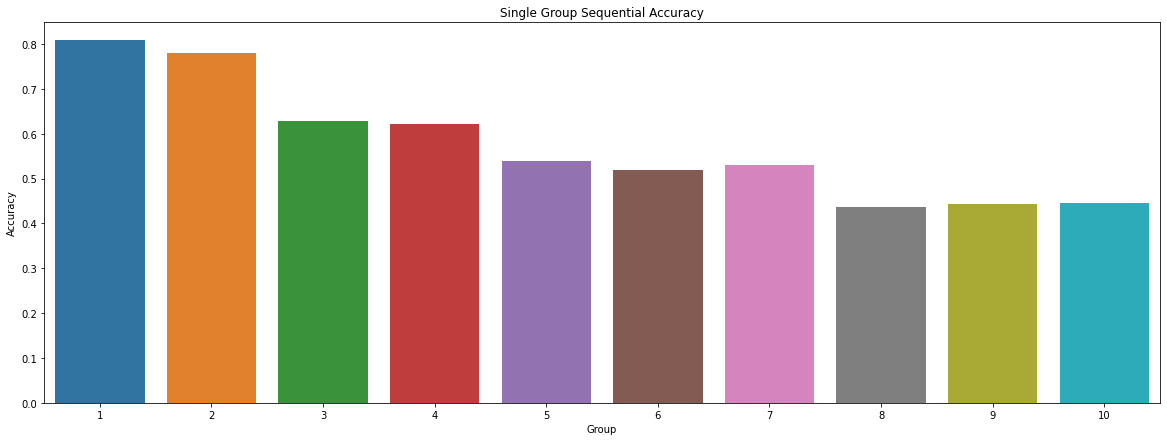

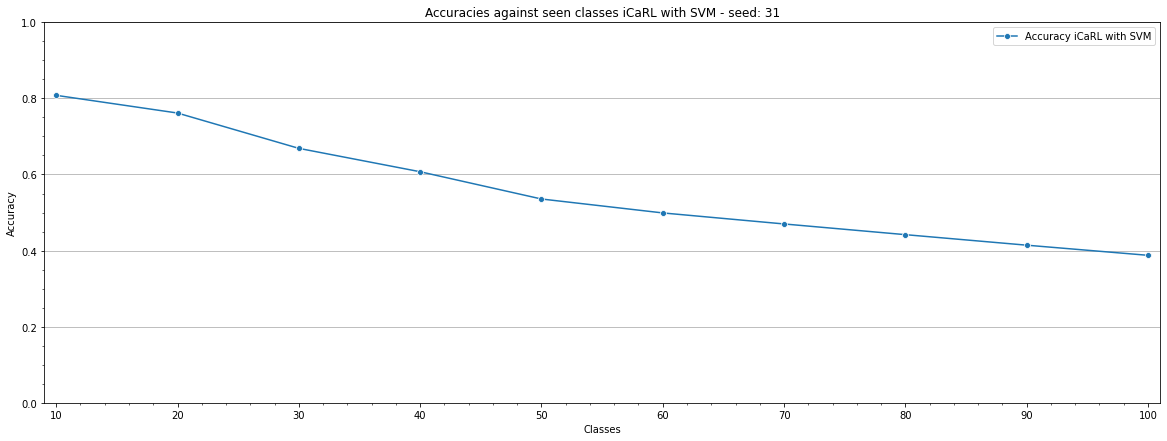

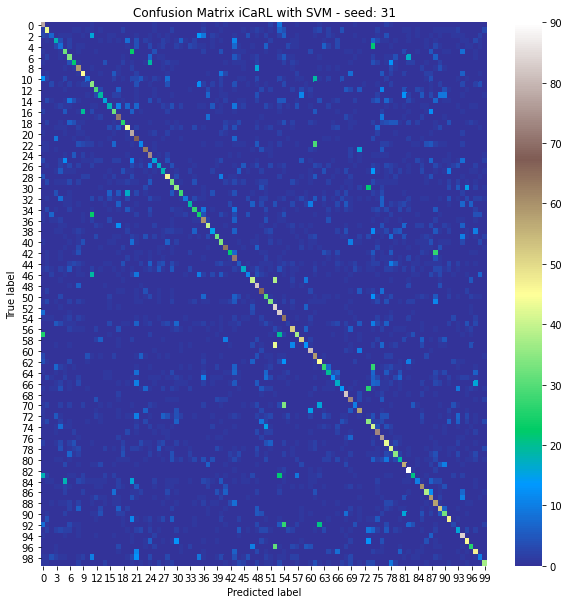

In [ ]:
method = "iCaRL with SVM"
print("metrics FINETUNING for seed {}".format(RANDOM_SEED))

data_plot_bar=[]
data_plot_line=[]
for id in range(0,10):
    data_plot_bar.append((id+1,old_accuracies[id]))
    data_plot_line.append(((id+1)*10,new_accuracies[id]))

plt.figure(figsize=(20,7))
accuracyDF=pd.DataFrame(data_plot_bar, columns = ['Group','Accuracy'])
ax = sns.barplot(x="Group", y="Accuracy",data=accuracyDF)
plt.title("Single Group Sequential Accuracy")
plt.show()

# plot accuracy trend
plotAccuracyTrend(method, data_plot_line, RANDOM_SEED)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
plotConfusionMatrix(method, confusionMatrixData, RANDOM_SEED)


##CLOSED AND OPEN WORLD

In [ ]:
#Dataset divided into 2 halves, 50 for closed 50 for open (choose five different random division)
#1) closed world
#  1.1)without rejection -> standard incremental scenario (train and test using selected 10 classes) but with 50 classes
#      iter = 0 -> 10 or 20 (he does so in BDOC) classes ? ask Dario
#      next iters -> add 10 until 50
#      result expected -> equal to incremental 
#
#  1.2)with rejection -> same procedure of above but we implement a rejection technique that 
#      classify as unknown an object that doesn't belong to the classes seen in the training (for the alg follow BDOC)
#      result expected -> idealistic the model should not reject any of the object because we've tested the model with classes seen in the training
#
#2) open world
#    at each step -> test the model only on unknown samples (the second half of dataset)
#    
#    result expected -> idealist the model should reject all of the test objects

###download and dividing dataset

In [16]:
# Import dataset and apply transformations 
train_dataset = CIFAR100(DATA_DIR, split='train', transform=train_transform)
test_dataset = CIFAR100(DATA_DIR, split='test', transform=eval_transform)

# Check datasets length 
print(len(train_dataset))
print(len(test_dataset))

50000
10000


In [17]:
#closed and open world
splits_of_10 = train_dataset.split_in_train_val_groups(ratio=0.99, seed=RANDOM_SEED)
#first 5 splits to closed world
closed_data = {k:splits_of_10[k] for k in range(5)}

#last 5 to open (removing the train val splits)
open = []
for k in range(5,10):
  for j in["train", "val"]:
    open += splits_of_10[k][j]

### Modified iCaRL for closed/open



#### Update representation

In [18]:
def updateRepresentation(net, train_subset, criterion, optimizer, scheduler, num_classes, group_id, K, exemplars_set_tot, old_net, rejection=False, closed=True):
  #exemplars_set_tot contiene tutti gli exemplars set ottenuti fino ad ora
  #train_iter contiene tutti i dati (immagini + labels) delle classi nuove (s, .., t)
  exemplars_subset = []
  exemplars_indices = []
  total_exemplars = []
  labels_tot = []

  for k, exemplar_set_class_k in exemplars_set_tot.items():
    # exemplar_set_class_k is the list of indices of images that belongs to the exemplar set selected for class k 
    if (exemplar_set_class_k != []):
      exemplars_subset = Subset(train_dataset, exemplar_set_class_k)
      total_exemplars = torch.utils.data.ConcatDataset([total_exemplars, exemplars_subset])

  if group_id > 1:
    train_subset_total = torch.utils.data.ConcatDataset([train_subset, total_exemplars])
  else:
    train_subset_total = train_subset
    
  print("Len TOTAL train susbset: ", len(train_subset_total))
  train_loader = torch.utils.data.DataLoader(train_subset_total, shuffle = True, batch_size=BATCH_SIZE, num_workers=2)
  # train_loader è la concatenazione delle nuove classi con gli exemplar_sets calcolati fino a questo punto 
  print("training")
  train(net, train_loader, criterion, optimizer, scheduler, num_classes, group_id, old_net, rejection = rejection, closed = closed)

#### Incremental train

In [19]:
import copy
def incrementalTrain(net, train_subset, criterion, optimizer, scheduler, num_classes_seen, group_id, K, exemplars_set_tot, old_net, total_classes_until_now, rejection=False, closed=True):
  print("Starting the update representation")
  exemplar_indices = None
  num_classes = 10
  new_classes_examined = list(train_dataset.df.loc[train_subset.indices, 'labels'].value_counts().index)
  print("NEW CLASSES: ", new_classes_examined)

  updateRepresentation(net, train_subset, criterion, optimizer, scheduler, num_classes_seen, group_id, K, exemplars_set_tot, old_net, rejection=rejection, closed=closed)
                
  iteration = group_id - 1
  t = (num_classes * iteration) + num_classes # num_classes ricevute fino a questo momento 
  m = int(K/t) #casto ad intero ? per difetto o eccesso?
  #s = num_classes * iteration

  # REDUCING EXEMPLAR SET FOR EXISTING CLASSES
  print("reducing exemplars for each class")
  print(total_classes_until_now)
  for y in total_classes_until_now: #ci serve un set con tutte le classi fino ad ora viste
    exemplar_y_new = reduceExemplarSet(m, exemplars_set_tot[y]) # valore associato alla chiave y che rappresenta il label della classe 
    print("REDUCED EXEMPLAR: ", len(exemplar_y_new))
    exemplars_set_tot[y] = exemplar_y_new

  
  # CONSTRUCTION EXEMPLAR SET FOR NEW CLASSES
  for y in new_classes_examined: # nuovi classi in arrivo di cui vogliamo costruire il set rappresentativo
    images_current_class = train_subset.dataset.df.loc[train_dataset.df['labels'] == y, 'data']
    imgs_idxs = images_current_class.index # the indexes of all the images in the current classe being considered 0...49k
    class_train_subset = Subset(train_dataset, imgs_idxs)#subset of the train dataset where i have all the imgs of class y
    print("class train: ", class_train_subset)
    print("Constructing exemplars of class", y)
    exemplars_set = constructExemplarSet(net, class_train_subset, m) # exemplar set è un set di indici
    #devo recuperare dal dataset iniziale l'indice delle immagini dell'exemplar set creato 
    #for image in exemplars_set:
     # exemplars_set = train_dataset.df.index[train_dataset.df['data'] == image].tolist()
    exemplars_set_tot[y] = exemplars_set
    print("exemplar set: ", exemplars_set)

#### train

In [20]:
def train(net, train_dataloader, criterion, optimizer, scheduler, num_classes_till_now, group_id, old_net, num_epochs=NUM_EPOCHS, rejection=False, closed=True, threshold=THRESHOLD):    

      
    num_classes_till_previous_step = group_id * 10 - 10
    print("num classes till now: ", num_classes_till_now)
    # network to GPU
    net = net.to(DEVICE) 

    cudnn.benchmark

    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    print(num_epochs)
    for epoch in range(num_epochs):
        
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        if rejection == True:
          n_sample_known = 0
          n_sample_unknown = 0
        for _, images, labels in train_dataloader:

            # Bring images and labels to GPU
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Labels encoding 
            labels_enc = _one_hot_encode(labels, num_classes_till_now, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad()

            # Forward pass
            features = net.forward(images)
            outputs = net.predict(features)

            #if iteration > 0, loss is the combination between the classification loss on new classes and the distillation loss on old classes
            if (group_id > 1):
              old_features = old_net.forward(images)
              old_outputs = old_net.predict(old_features)
              labels_enc[:,0:num_classes_till_previous_step] = torch.sigmoid(old_outputs)

            loss = computeLoss(criterion, outputs, labels_enc)
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)

            


            if rejection == True:
              prediction_batch = outputs.data.cpu().numpy()
              for i in range(len(prediction_batch)):
                current_softmax = softmax(prediction_batch[i])
                if max(current_softmax)>THRESHOLD:
                  n_sample_known += 1
                else:
                  n_sample_unknown += 1
       

            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        if rejection == True:
          if closed == True:
            epoch_acc = n_sample_known / float(len(train_dataloader.dataset))
            numb = n_sample_known
          else:
            epoch_acc = n_sample_unknown / float(len(train_dataloader.dataset))
            numb = n_sample_unknown
        else:
          epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, numb))
    print('Training finished in {} seconds'.format(time.time() - start_time))

#### validate

In [21]:
def validate(net, val_dataloader, criterion, num_classes, rejection = False, closed = False):
    #counter for rejection part, known and unknown
    if rejection==True:
      n_sample_known = 0
      n_sample_unknown = 0
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(images)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)
            
        _, preds = torch.max(outputs.data, 1)
        if rejection == True:
          prediction_batch = outputs.data.cpu().numpy()
          print(len(prediction_batch))
          for i in range(len(prediction_batch)):
            current_softmax = softmax(prediction_batch[i])
            if max(current_softmax)>THRESHOLD:
              n_sample_known += 1
            else:
              n_sample_unknown += 1
        else:
          #_, preds = classify(images, )
          running_corrects += torch.sum(preds == labels.data).data.item()

          all_preds_cm.extend(preds.tolist())
          all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    if rejection == True:
      if closed == True:
        acc = n_sample_known / float(len(val_dataloader.dataset))
      else:
        acc = n_sample_unknown / float(len(val_dataloader.dataset))
    else:
      acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes, rejection = False, closed = True):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes, rejection, closed)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

#### sequentialLearningiCaRL

In [22]:
def sequentialLearningiCaRL(train_subsets, val_subsets, test_subsets, rejection = False, closed = True):
    net, criterion, optimizer, scheduler = getResNet32()
    test_set = None
    groups_accuracies=[]
    all_accuracies=[]
    group_id=1

    K = 2000
    iterations = 5
    num_classes = 10
    exemplars_set_tot = {new_list: [] for new_list in range(100)}
    labels_train = []
    total_classes_seen = []

    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
      
      train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)

      print("TRAIN: ", len(train_subset))
      if test_set is None:
        test_set = test_subset
        old_net = copy.deepcopy(net)
        old_net.to(DEVICE)
        addOutputs(net,10)
      else:
        test_set = joinSubsets(test_dataset, [test_set, test_subset])
        old_net = copy.deepcopy(net)
        old_net.to(DEVICE)
        addOutputs(net,10)
      
      print("TEST SET LENGHT: ", len(test_set))
      print("TEST CURRENT GROUP SET LENGHT: ", len(test_subset))
      num_classes_per_group = 10
      num_classes_seen = group_id*10

      test_classes = list(test_dataset.df.loc[test_set.indices, 'labels'].value_counts().index)
      train_classes = list(train_dataset.df.loc[train_subset.indices, 'labels'].value_counts().index)
      validation_classes = list(train_dataset.df.loc[val_subset.indices, 'labels'].value_counts().index)
      for i in train_classes:
        total_classes_seen.append(i)
      print("TEST_SET CLASSES: ", test_classes)
      print("TRAIN_SET CLASSES: ", train_classes)
      print("VALIDATION CLASSES: ", validation_classes)
      print("GROUP: ",group_id)
      # Train on current group
      optimizer, scheduler = getSchedulerOptimizer(net) # reset learning rate and step_size

      incrementalTrain(net, train_subset, criterion, optimizer, scheduler, num_classes_seen, group_id, K, exemplars_set_tot, old_net, total_classes_seen, rejection=rejection, closed=closed) # Train the network with 10 classes at a time

      # Validate on current group
      val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc, loss, _, _ = validate(net, val_loader, criterion, num_classes_seen, exemplars_set_tot, rejection=rejection, closed=closed)
      print("EVALUATION: ",acc, loss)

      # Test on current group
      test_group_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_group, _, _ = test(net, test_group_loader, num_classes_seen, exemplars_set_tot, rejection=rejection, closed=closed)
      groups_accuracies.append(acc_group)

      test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_all, all_preds_cm, all_labels_cm = test(net, test_loader, num_classes_seen, exemplars_set_tot)
      all_accuracies.append(acc_all)
      
      print("TEST GROUP: ",acc_group)
      print("TEST ALL: ",acc_all)
      group_id+=1

    return net, groups_accuracies, all_accuracies, all_preds_cm, all_labels_cm


### Closed World

In [23]:
# Reverse indexing for closed and open world
outputs_labels_mapping = ReverseIndex(train_dataset, splits_of_10)
print(outputs_labels_mapping.getGroups())

# TEST split
test_splits = build_test_splits(test_dataset, outputs_labels_mapping)
#above are 10 splits but I want 5 for closed and 5 for open
test_splits_closed = {i:test_splits[i] for i in range(5)}
test_splits_open = []
for i in range(5,10):
  test_splits_open += test_splits[i]

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')


In [24]:
df = pd.DataFrame()
for i in outputs_labels_mapping.getGroups():
  print(outputs_labels_mapping.getLabelsOfGroup(i))

0    27
1    86
2    82
3    78
4    50
5    30
6    97
7    69
8    57
9    25
Name: labels, dtype: object
10    95
11    59
12    58
13    34
14    81
15    49
16    13
17    88
18    68
19    60
Name: labels, dtype: object
20    35
21     3
22    94
23    10
24    45
25    37
26    80
27    72
28    36
29    24
Name: labels, dtype: object
30    31
31    11
32    98
33    77
34    53
35    33
36    96
37    92
38    52
39    12
Name: labels, dtype: object
40    91
41    67
42     7
43    62
44    46
45    65
46    21
47    32
48    16
49     0
Name: labels, dtype: object
50    79
51    71
52    63
53    26
54    14
55     2
56    73
57    41
58    56
59    48
Name: labels, dtype: object
60    99
61    23
62    66
63    22
64     6
65    93
66    17
67     5
68     1
69    28
Name: labels, dtype: object
70    87
71    75
72    55
73    47
74    39
75    70
76    42
77    38
78    29
79     4
Name: labels, dtype: object
80    83
81    51
82    18
83    89
84    85
85     9
86    84
87 

In [25]:
train_subsets = []
val_subsets = []
test_subsets = []

for v in closed_data.values():
    train_subs = Subset(train_dataset, v['train'])
    val_subs = Subset(train_dataset, v['val'])
    train_subsets.append(train_subs)
    val_subsets.append(val_subs)

for i in range(0,5):
    v=test_splits_closed[i]
    test_subs = Subset(test_dataset, v)
    test_subsets.append(test_subs)

In [26]:
#for the test of open world
open_test = Subset(test_dataset, test_splits_open)

In [27]:
targets_open = set()
for i in range(len(open_test.indices)):
  targets_open.add(test_dataset.__getitem__(open_test.indices[i])[2])

In [28]:
targets_closed = set()
for k in test_splits_closed:
  for j in range(len(test_splits_closed[k])):
    targets_closed.add(test_dataset.__getitem__(test_splits_closed[k][j])[2])

In [29]:
#verifing that there aren't objects of the same class
list(targets_closed.intersection(targets_open))

[]

### Closed world without rejection

In [ ]:
#without rejection
rejection = False
closed = True
# train
net, old_accuracies, new_accuracies, all_preds_cm, all_labels_cm = sequentialLearningiCaRL(train_subsets, val_subsets, test_subsets)

In [ ]:
method = "Closed world without Rejection"
print("metrics ClosedWord for seed {}".format(RANDOM_SEED))

data_plot_bar=[]
data_plot_line=[]
for id in range(0,5):
    data_plot_bar.append((id+1,old_accuracies[id]))
    data_plot_line.append(((id+1)*10,new_accuracies[id]))

plt.figure(figsize=(20,7))
accuracyDF=pd.DataFrame(data_plot_bar, columns = ['Group','Accuracy'])
ax = sns.barplot(x="Group", y="Accuracy",data=accuracyDF)
plt.title("Single Group Sequential Accuracy")
plt.show()

# plot accuracy trend
plotAccuracyTrend(method, data_plot_line, RANDOM_SEED)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
plotConfusionMatrix(method, confusionMatrixData, RANDOM_SEED)

# write down json
writeMetrics(method, RANDOM_SEED, accuracies, confusionMatrixData)

### Closed world with rejection

In [ ]:
# train closed world with rejection
rejection = True
closed = True
net, old_accuracies, new_accuracies, all_preds_cm, all_labels_cm = sequentialLearningiCaRL(train_subsets, val_subsets, test_subsets, rejection=rejection, closed=closed)

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TRAIN:  4950
TEST SET LENGHT:  1000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [97, 86, 82, 78, 69, 57, 50, 30, 27, 25]
TRAIN_SET CLASSES:  [27, 86, 82, 78, 50, 30, 97, 69, 57, 25]
VALIDATION CLASSES:  [57, 50, 97, 30, 27, 25, 86, 82, 78, 69]
GROUP:  1
Starting the update representation
NEW CLASSES:  [27, 86, 82, 78, 50, 30, 97, 69, 57, 25]
Len TOTAL train susbset:  4950
training
num classes till now:  10
70
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.7325664758682251
Train step - Step 10, Loss 0.2953501045703888
Train step - Step 20, Loss 0.2760721743106842
Train step - Step 30, Loss 0.24793823063373566
Train epoch - Accuracy: 0.201010101010101 Loss: 0.3388997777242853 Corrects: 995
Starting epoch 2/70, LR = [0.1]
Train step - Step 40, Loss 0.2608705461025238
Train step - Step 50, Loss 0.22912640869617462
Train step - Step 60, Loss 0.24861787259578705
Train step - Step 70, Loss 0.20971480011940002
Train epoch - Accuracy: 0.35555555555555557 Loss: 0.23450849609543578 Corrects: 1760
Starting epoch 3/70, LR = [0.1]
Train step - Step 80, Loss 0.210896298289299
Train step - Step 90, Loss 0.2240062803030014
Train step - Step 100, Loss 0.2282872200012207
Train step - Step 110, Loss 0.20540164411067963
Train epoch - Accuracy: 0.46101010101010104 Loss: 0.21774203690615568 Corrects: 2282
Starting epoch 4/70, LR = [0.1]
Train step - Step 120, Loss 0.21012310683727264
Train step - Step 130, Loss 0.1885118931531906
T

metrics ClosedWord for seed 66


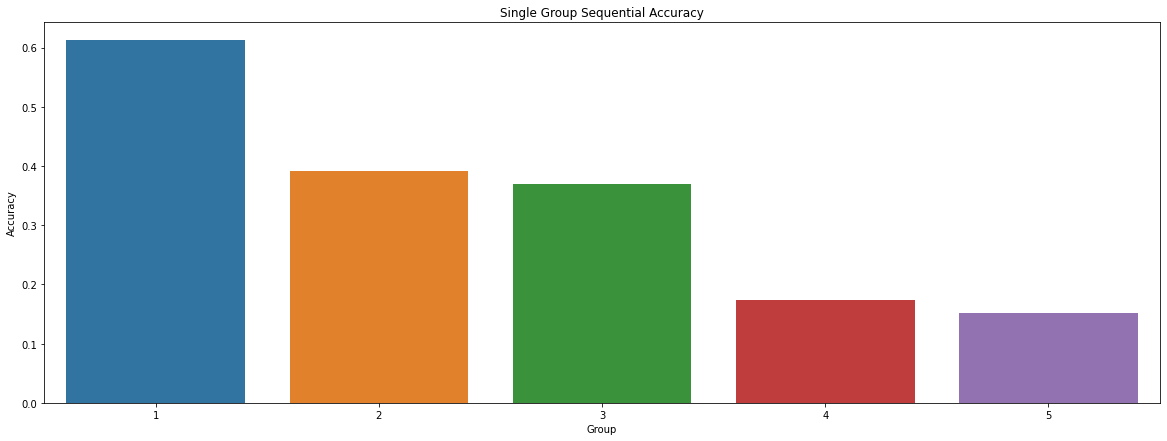

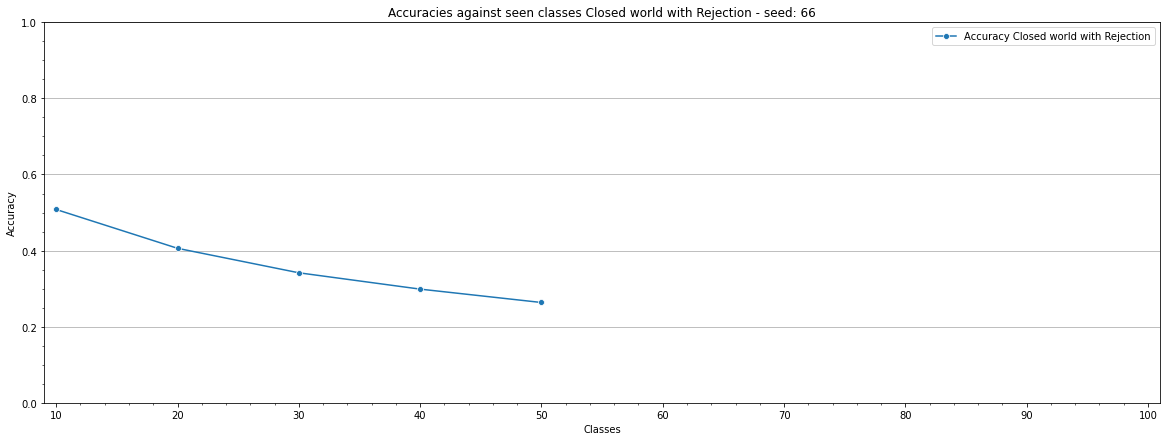

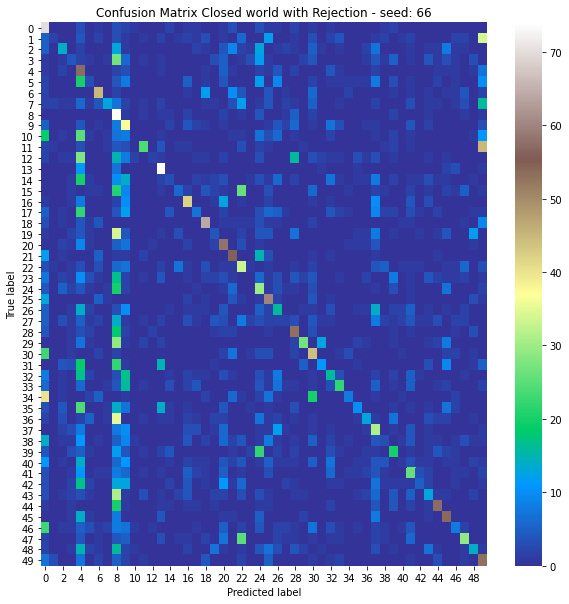

In [ ]:
method = "Closed world with Rejection"
print("metrics ClosedWord for seed {}".format(RANDOM_SEED))

data_plot_bar=[]
data_plot_line=[]
for id in range(0,5):
    data_plot_bar.append((id+1,old_accuracies[id]))
    data_plot_line.append(((id+1)*10,new_accuracies[id]))

plt.figure(figsize=(20,7))
accuracyDF=pd.DataFrame(data_plot_bar, columns = ['Group','Accuracy'])
ax = sns.barplot(x="Group", y="Accuracy",data=accuracyDF)
plt.title("Single Group Sequential Accuracy")
plt.show()

# plot accuracy trend
plotAccuracyTrend(method, data_plot_line, RANDOM_SEED)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
plotConfusionMatrix(method, confusionMatrixData, RANDOM_SEED)

# write down json
 #writeMetrics(method, RANDOM_SEED, accuracies, confusionMatrixData)

In [ ]:
closed_with_rej_acc = new_accuracies
print(closed_with_rej_acc)

[0.508, 0.406, 0.3416666666666667, 0.29875, 0.2636]


### open world with rejection

In [58]:
def sequentialLearningiCaRLOpen(train_subsets, val_subsets, open_dataset, rejection = False, closed = True):
    net, criterion, optimizer, scheduler = getResNet32()
    all_accuracies=[]
    group_id=1

    K = 2000
    iterations = 5
    num_classes = 10
    exemplars_set_tot = {new_list: [] for new_list in range(100)}
    labels_train = []
    total_classes_seen = []

    for train_subset, val_subset in zip(train_subsets, val_subsets):
      
      train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      print("BATCH SIZE: ", BATCH_SIZE )
      print("TRAIN: ", len(train_subset))
      old_net = copy.deepcopy(net)
      old_net.to(DEVICE)
      addOutputs(net,10)
    
    
      num_classes_per_group = 10
      num_classes_seen = group_id*10

      train_classes = list(train_dataset.df.loc[train_subset.indices, 'labels'].value_counts().index)
      validation_classes = list(train_dataset.df.loc[val_subset.indices, 'labels'].value_counts().index)
      for i in train_classes:
        total_classes_seen.append(i)
      print("TRAIN_SET CLASSES: ", train_classes)
      print("VALIDATION CLASSES: ", validation_classes)
      print("GROUP: ",group_id)
      # Train on current group
      optimizer, scheduler = getSchedulerOptimizer(net) # reset learning rate and step_size

      incrementalTrain(net, train_subset, criterion, optimizer, scheduler, num_classes_seen, group_id, K, exemplars_set_tot, old_net, total_classes_seen, rejection=rejection, closed=closed) # Train the network with 10 classes at a time

      # Validate on current group
      
      # val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      # acc, loss, _, _ = validate(net, val_loader, criterion, num_classes_seen, rejection=rejection, closed=closed)
      # print("EVALUATION: ",acc, loss)

      #if(group_id ==5):
      """ modify batch size for the variation """
      #num_classes_seen=100
      test_loader = DataLoader(open_dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=False)
      acc_all, all_preds_cm, all_labels_cm = test(net, test_loader, 100, exemplars_set_tot, rejection, closed)
      all_accuracies.append(acc_all)
      print("TEST ALL: ",acc_all)
      group_id+=1

    return net, all_accuracies, all_preds_cm, all_labels_cm

In [59]:
def meanExemplars(exemplar_set, net):
  exemplars_subset = []
  exemplar_loader = []
  toReturn = {}
  for k, exemplar_set_class_k in exemplar_set.items():
      distances = []
      # exemplar_set_class_k is the list of indices of images that belongs to the exemplar set selected for class k 
      if (exemplar_set_class_k != []):
        exemplars_subset = Subset(train_dataset, exemplar_set_class_k)
        # print(exemplars_subset.__len__())
        if exemplars_subset.__len__()==200:
            exemplar_loader = torch.utils.data.DataLoader(exemplars_subset, shuffle = True, batch_size=128, num_workers=2, drop_last=True)
        else:
            exemplar_loader = torch.utils.data.DataLoader(exemplars_subset, shuffle = True, batch_size=exemplars_subset.__len__(), num_workers=2)
            
        for _, exemplars, labels  in exemplar_loader:
          exemplars = exemplars.to(DEVICE)  
          feature_exemplar = net.forward(exemplars).detach().cpu().numpy()
          del exemplars #delete unnecessary variables 
          gc.collect()  
          #print(feature_exemplar.shape) #len_exemplar_subset * 64
          mean_feature_exemplar = feature_exemplar.mean(axis=0) # expected shape -> 1*64
          #print(mean_feature_exemplar)
          del feature_exemplar
          gc.collect()
          toReturn[k] = mean_feature_exemplar
          # print(len(toReturn))
  return toReturn      

In [30]:
import gc
from scipy.special import softmax

def validate(net, val_dataloader, criterion, num_classes, exemplar_set, rejection = False, closed = False):
    #counter for rejection part, known and unknown
    print("START VALIDATE!!!!!!!")
    rejection = True
    if rejection==True:
      n_sample_known = 0
      n_sample_unknown = 0
    net.eval()
    exemplars_subset = []
    exemplar_loader = [] 

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []
    # print(len(val_dataloader))
    running_corrects = 0
    running_loss = 0.0
    # print(exemplar_set)

    #mean of feature exemplars for each class of this iteration, is a dict class -> mean of features  (1,64)

    print("I am calculating the mean of the exemplars...")
    mean_exemplars = meanExemplars(exemplar_set, net)
    print("...Mean of the exemplars done!!")


    for _, image, labels in val_dataloader:
        #print('ciclo immagini')
        # Bring images and labels to GPU
        image = image.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(image)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * image.size(0)
            
        _, preds = torch.max(outputs.data, 1)

        if rejection == True:
          #passare exemplar_set_tot
          reject = True
          feature = net.forward(image)
          # 128 * 64
          #print(feature.shape)
          mean_image = []
          cos = nn.CosineSimilarity(dim=1, eps=1e-6)
          
          distances = []
          dist = 0
          
          for k, mean in mean_exemplars.items(): #k-> class
            adjusted_mean = torch.tensor((np.ones(shape = (len(labels),1))*mean)).to(DEVICE)
            output = (cos(adjusted_mean, feature)) # ex1 128distanze 
            output = output.detach().cpu().numpy() #128x1
            distances.append(output) # 128xnum_classes
          #print('DISTANZE: ', distances) # 128xnum_classes, distances of every image from each class
            # 128 * num_classes

          # normalized_vector = (distances- np.mean(distances, axis = 0)) / np.std(distances, axis = 0)
          # print("DISTANCES: ", distances)
          #softmax the normalized vector then take the maximum for each row, masking to true or false with the threshold
          #if the sum of the vector is > 0 -> at least one value above 0.5 so image is known
          threshold = 0.8
          distances_np = np.array(distances)
          flag_known = (distances_np.max(axis=0)>threshold).sum()
         
          n_sample_known += flag_known
          n_sample_unknown += ( image.size(0) - flag_known)
                    
          #for values in normalized_vector:
          #  for value in values:
          #    if (value < 0.5):
          #      reject = False
          #  if (reject == False):
          #    n_sample_known += 1
          #  else:
          #    n_sample_unknown += 1
        # if rejection == True:
        #   prediction_batch = outputs.data.cpu().numpy()
        #   print("OUTPUTS shape: ", outputs.data.shape)
        #   print("LEN PRED BATCH:", len(prediction_batch))
        #   for i in range(len(prediction_batch)):
        #     current_softmax = softmax(prediction_batch[i])
        #     #print(max(current_softmax))
        #     if max(current_softmax)>THRESHOLD:
        #       n_sample_known += 1
        #     else:
        #       n_sample_unknown += 1
        else:
          #_, preds = classify(images, )
          running_corrects += torch.sum(preds == labels.data).data.item()

          all_preds_cm.extend(preds.tolist())
          all_labels_cm.extend(labels.data.tolist())
          
    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    if rejection == True:
      if closed == True:
        acc = n_sample_known / float(len(val_dataloader.dataset))
      else:
        acc = n_sample_unknown / float(len(val_dataloader.dataset))
    else:
      acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes, exemplar_set, rejection = False, closed = True):
    # acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes, exemplar_set, rejection, closed)
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes, exemplar_set, rejection, closed)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

In [61]:
#open with rejection
rejection = True
closed = False
# train
net, new_accuracies, all_preds_cm, all_labels_cm = sequentialLearningiCaRLOpen(train_subsets, val_subsets, open_test, rejection=rejection, closed=closed)

BATCH SIZE:  128
TRAIN:  4950
TRAIN_SET CLASSES:  [27, 86, 82, 78, 50, 30, 97, 69, 57, 25]
VALIDATION CLASSES:  [57, 50, 97, 30, 27, 25, 86, 82, 78, 69]
GROUP:  1
Starting the update representation
NEW CLASSES:  [27, 86, 82, 78, 50, 30, 97, 69, 57, 25]
Len TOTAL train susbset:  4950
training
num classes till now:  10
70
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.6837897300720215
Train step - Step 10, Loss 0.3141202926635742
Train step - Step 20, Loss 0.277765691280365
Train step - Step 30, Loss 0.25492697954177856
Train epoch - Accuracy: 0.8309090909090909 Loss: 0.331034652656979 Corrects: 4113
Starting epoch 2/70, LR = [0.1]
Train step - Step 40, Loss 0.2501177489757538
Train step - Step 50, Loss 0.21974359452724457
Train step - Step 60, Loss 0.24579834938049316
Train step - Step 70, Loss 0.24298842251300812
Train epoch - Accuracy: 0.6527272727272727 Loss: 0.23977305104636182 Corrects: 3231
Starting epoch 3/70, LR = [0.1]
Train step - Step 80, Loss 0.21840213239192963
Train step - Step 90, Loss 0.24193596839904785
Train step - Step 100, Loss 0.21606695652008057
Train step - Step 110, Loss 0.22050617635250092
Train epoch - Accuracy: 0.553939393939394 Loss: 0.22319429768456353 Corrects: 2742
Starting epoch 4/70, LR = [0.1]
Train step - Step 120, Loss 0.24116496741771698
Train step - Step 130, Loss 0.2171279937028885


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


...Mean of the exemplars done!!
TEST ALL:  0.6108
BATCH SIZE:  128
TRAIN:  4950
TRAIN_SET CLASSES:  [95, 59, 58, 34, 81, 49, 13, 88, 68, 60]
VALIDATION CLASSES:  [60, 59, 58, 49, 34, 95, 88, 81, 13, 68]
GROUP:  2
Starting the update representation
NEW CLASSES:  [95, 59, 58, 34, 81, 49, 13, 88, 68, 60]
Len TOTAL train susbset:  6950
training
num classes till now:  20
70
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.408018559217453
Train step - Step 10, Loss 0.1748546063899994
Train step - Step 20, Loss 0.15310008823871613
Train step - Step 30, Loss 0.1482415646314621
Train step - Step 40, Loss 0.1407526731491089
Train step - Step 50, Loss 0.14017365872859955
Train epoch - Accuracy: 0.2706474820143885 Loss: 0.16617167992128742 Corrects: 1881
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.1339963674545288
Train step - Step 70, Loss 0.1403830498456955
Train step - Step 80, Loss 0.12755922973155975
Train step - Step 90, Loss 0.13530749082565308
Train step - Step 100, Loss 0.13424520194530487
Train epoch - Accuracy: 0.24661870503597122 Loss: 0.12835007987434058 Corrects: 1714
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.12332966178655624
Train step - Step 120, Loss 0.11680948734283447
Train step - Step 130, Loss 0.1294112205505371
Train step - Step 140, Loss 0.11977863311767578
Train step - Step 150, Loss 0.12390263378620148
Train step - Step 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


...Mean of the exemplars done!!
TEST ALL:  0.616
BATCH SIZE:  128
TRAIN:  4950
TRAIN_SET CLASSES:  [35, 3, 94, 10, 45, 37, 80, 72, 36, 24]
VALIDATION CLASSES:  [45, 37, 36, 35, 94, 24, 80, 10, 72, 3]
GROUP:  3
Starting the update representation
NEW CLASSES:  [35, 3, 94, 10, 45, 37, 80, 72, 36, 24]
Len TOTAL train susbset:  6950
training
num classes till now:  30
70
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.39127880334854126
Train step - Step 10, Loss 0.1588975340127945
Train step - Step 20, Loss 0.15261223912239075
Train step - Step 30, Loss 0.1311495304107666
Train step - Step 40, Loss 0.1287691593170166
Train step - Step 50, Loss 0.13443627953529358
Train epoch - Accuracy: 0.3375539568345324 Loss: 0.15879740954303057 Corrects: 2346
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.12388765066862106
Train step - Step 70, Loss 0.11988617479801178
Train step - Step 80, Loss 0.11909811198711395
Train step - Step 90, Loss 0.12249014526605606
Train step - Step 100, Loss 0.13479270040988922
Train epoch - Accuracy: 0.33223021582733814 Loss: 0.12177895502220812 Corrects: 2309
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.12176526337862015
Train step - Step 120, Loss 0.12207755446434021
Train step - Step 130, Loss 0.11556089669466019
Train step - Step 140, Loss 0.12274934351444244
Train step - Step 150, Loss 0.12046191096305847
Train step - 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


...Mean of the exemplars done!!
TEST ALL:  0.7126
BATCH SIZE:  128
TRAIN:  4950
TRAIN_SET CLASSES:  [31, 11, 98, 77, 53, 33, 96, 92, 52, 12]
VALIDATION CLASSES:  [53, 52, 98, 33, 96, 31, 92, 77, 12, 11]
GROUP:  4
Starting the update representation
NEW CLASSES:  [31, 11, 98, 77, 53, 33, 96, 92, 52, 12]
Len TOTAL train susbset:  6930
training
num classes till now:  40
70
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.3093474805355072
Train step - Step 10, Loss 0.1432926505804062
Train step - Step 20, Loss 0.13307015597820282
Train step - Step 30, Loss 0.13052375614643097
Train step - Step 40, Loss 0.12178993225097656
Train step - Step 50, Loss 0.11950962990522385
Train epoch - Accuracy: 0.366955266955267 Loss: 0.14125408243393314 Corrects: 2543
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.11498947441577911
Train step - Step 70, Loss 0.10375595092773438
Train step - Step 80, Loss 0.11707358807325363
Train step - Step 90, Loss 0.12091328948736191
Train step - Step 100, Loss 0.10713545233011246
Train epoch - Accuracy: 0.3424242424242424 Loss: 0.11284475112159187 Corrects: 2373
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.10186871141195297
Train step - Step 120, Loss 0.11402306705713272
Train step - Step 130, Loss 0.11146736145019531
Train step - Step 140, Loss 0.1056932583451271
Train step - Step 150, Loss 0.11127535253763199
Train step - St

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


...Mean of the exemplars done!!
TEST ALL:  0.6984
BATCH SIZE:  128
TRAIN:  4950
TRAIN_SET CLASSES:  [91, 67, 7, 62, 46, 65, 21, 32, 16, 0]
VALIDATION CLASSES:  [62, 46, 32, 91, 21, 16, 7, 67, 65, 0]
GROUP:  5
Starting the update representation
NEW CLASSES:  [91, 67, 7, 62, 46, 65, 21, 32, 16, 0]
Len TOTAL train susbset:  6950
training
num classes till now:  50
70
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.29321783781051636
Train step - Step 10, Loss 0.14722761511802673
Train step - Step 20, Loss 0.13995756208896637
Train step - Step 30, Loss 0.13692544400691986
Train step - Step 40, Loss 0.12730672955513
Train step - Step 50, Loss 0.12666916847229004
Train epoch - Accuracy: 0.47784172661870505 Loss: 0.14437141668667897 Corrects: 3321
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.12012088298797607
Train step - Step 70, Loss 0.11550794541835785
Train step - Step 80, Loss 0.11194560676813126
Train step - Step 90, Loss 0.11637410521507263
Train step - Step 100, Loss 0.12011498957872391
Train epoch - Accuracy: 0.46014388489208635 Loss: 0.11681348353409939 Corrects: 3198
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.11357762664556503
Train step - Step 120, Loss 0.11658252775669098
Train step - Step 130, Loss 0.11574000120162964
Train step - Step 140, Loss 0.1192956492304802
Train step - Step 150, Loss 0.1161159873008728
Train step - S

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


...Mean of the exemplars done!!
TEST ALL:  0.714


## PLOT 


In [ ]:
import numpy as np
run1 = np.array([0.823,	0.447,	0.286,	0.1985,	0.163,	0.1428,	0.126,	0.098,	0.0953, 0.086])
run2 = np.array([0.75, 0.438, 0.285, 0.218, 0.17, 0.14, 0.12, 0.1, 0.09, 0.08])
run3 = np.array([0.817, 0.44, 0.27, 0.206, 0.168, 0.1442, 0.125, 0.101, 0.0912, 0.0831])

finetuning = np.array([run1, run2, run3])
mean = np.mean(finetuning, axis = 0)
std = np.std(finetuning, axis = 0)

run1l = np.array([0.816,	0.683,	0.6006,	0.52175,	0.4666,	0.4365,	0.4108,	0.378,	0.3486, 0.3226])
run2l = np.array([0.769, 0.6445, 0.5563, 0.46675, 0.4362, 0.4105, 0.3772, 0.35075, 0.3262, 0.3104])
run3l = np.array([0.825, 0.6625, 0.572, 0.47125, 0.4132, 0.3883, 0.369, 0.3485, 0.3325, 0.3149])
LWF = np.array([run1l, run2l, run3l])
meanLWF = np.mean(LWF, axis = 0)
stdLWF = np.std(LWF, axis = 0)

run1c = np.array([0.812,	0.7385,	0.6893,	0.62025,	0.582,	0.5628,	0.538,	0.5166,	0.4948, 0.482])
run2c = np.array([0.754, 0.7185, 0.662, 0.608, 0.5796, 0.5598, 0.5278, 0.5005, 0.4985, 0.4707])
run3c = np.array([0.833, 0.759, 0.695, 0.6367, 0.5966, 0.5823, 0.545, 0.52125, 0.495, 0.4947])
iCaRL = np.array([run1c, run2c, run3c])
meaniCaRL = np.mean(iCaRL, axis = 0)
stdiCaRL = np.std(iCaRL, axis = 0)


In [ ]:
stdLWF

array([0.0245538 , 0.0157286 , 0.01833921, 0.02493436, 0.02187012,
       0.01969794, 0.01808449, 0.01340761, 0.00943198, 0.00503742])

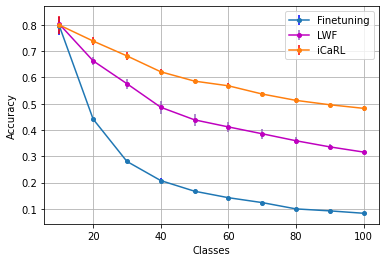

In [ ]:
import matplotlib.pyplot as plt
x = np.linspace(10,100, num = 10)
plt.show()
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.grid()
plt.errorbar(x, mean,yerr=std, linestyle="-", marker = 'o', markersize = 4, ecolor='blue', color = 'tab:blue')
plt.errorbar(x, meanLWF, yerr=stdLWF, linestyle="-", marker = 'o', markersize = 4, ecolor='tab:purple', color = 'm')
plt.errorbar(x, meaniCaRL, yerr=stdiCaRL, linestyle="-", marker = 'o', markersize = 4, ecolor='r', color = 'tab:orange')
plt.legend(['Finetuning', 'LWF', 'iCaRL'])
#plt.show()
plt.savefig("plot.pdf")

In [ ]:
import numpy as np

In [ ]:
run1CEL1 = np.array([0.751,0.713,0.607,0.5175,0.5032,0.48233333333333334,0.475228571428571426,0.463625,0.4451,0.435])
run2CEL1 = np.array([0.804, 0.701, 0.632, 0.5235, 0.498, 0.4877, 0.47025, 0.46806, 0.4591244, 0.4431])
run3CEL1 = np.array([0.829, 0.747, 0.669, 0.56475, 0.5342, 0.495, 0.487571428571429, 0.471225, 0.46175, 0.4501])
CEl1 = np.array([run1CEL1, run2CEL1, run3CEL1])
meanCEl1 = np.mean(CEl1, axis = 0)
stdCEl1 = np.std(CEl1, axis = 0)

run1c = np.array([0.812,	0.7385,	0.6893,	0.62025,	0.582,	0.5628,	0.538,	0.5166,	0.4948, 0.4862])
run2c = np.array([0.754, 0.7185, 0.662, 0.608, 0.5796, 0.5598, 0.5278, 0.5005, 0.4985, 0.4707])
run3c = np.array([0.833, 0.759, 0.695, 0.6367, 0.5966, 0.5823, 0.545, 0.52125, 0.495, 0.4847])
iCaRL = np.array([run1c, run2c, run3c])
meaniCaRL = np.mean(iCaRL, axis = 0)
stdiCaRL = np.std(iCaRL, axis = 0)

runCEBCE = np.array([0.84, 0.785, 0.7133333333333334, 0.664, 0.5748, 0.541, 0.4888571428571429, 0.45875, 0.43922222222222224, 0.4009])

runCEKlDiv = np.array([0.832, 0.7945, 0.685, 0.6205, 0.5372, 0.49583333333333335, 0.4667142857142857, 0.419125, 0.39222222222222225, 0.3614])

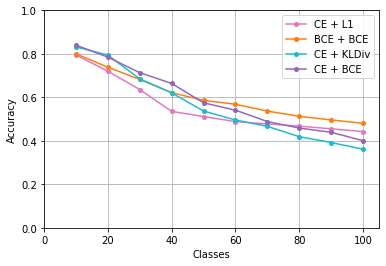

In [ ]:
import matplotlib.pyplot as plt
x = np.linspace(10,100, num = 10)
plt.show()
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.grid()
plt.errorbar(x, meanCEl1, linestyle="-", marker = 'o', markersize = 4, ecolor='k', color = 'tab:pink')
plt.errorbar(x, meaniCaRL, linestyle="-", marker = 'o', markersize = 4, ecolor='k', color = 'tab:orange')
plt.errorbar(x, runCEKlDiv, linestyle="-", marker = 'o', markersize = 4, ecolor='k', color = 'tab:cyan')
plt.errorbar(x, runCEBCE, linestyle="-", marker = 'o', markersize = 4, ecolor='k', color = 'tab:purple')
plt.axis([0, 105, 0, 1])
plt.legend(['CE + L1', 'BCE + BCE', 'CE + KLDiv', 'CE + BCE'])
#plt.show()
plt.savefig("losses.pdf")

In [ ]:
runSVM = np.array([0.808, 0.7615, 0.6686666666666666,0.60725,0.5356,0.499,0.47,0.441875,0.4142222222222222,0.3876])

runKNN = np.array([0.853, 0.797, 0.68, 0.632, 0.547, 0.5197, 0.503, 0.489, 0.475, 0.455])


run1c = np.array([0.812,	0.7385,	0.6893,	0.62025,	0.582,	0.5628,	0.538,	0.5166,	0.4948, 0.4862])
run2c = np.array([0.754, 0.7185, 0.662, 0.608, 0.5796, 0.5598, 0.5278, 0.5005, 0.4985, 0.4707])
run3c = np.array([0.833, 0.759, 0.695, 0.6367, 0.5966, 0.5823, 0.545, 0.52125, 0.495, 0.4847])
iCaRL = np.array([run1c, run2c, run3c])
meaniCaRL = np.mean(iCaRL, axis = 0)
stdiCaRL = np.std(iCaRL, axis = 0)

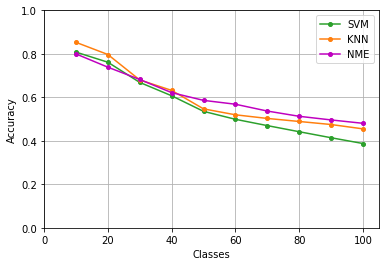

In [ ]:
import matplotlib.pyplot as plt
x = np.linspace(10,100, num = 10)
plt.show()
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.grid()
plt.errorbar(x, runSVM, linestyle="-", marker = 'o', markersize = 4, ecolor='k', color = 'tab:green')
plt.errorbar(x, runKNN, linestyle="-", marker = 'o', markersize = 4, ecolor='k', color = 'tab:orange')
plt.errorbar(x, meaniCaRL, linestyle="-", marker = 'o', markersize = 4, ecolor='k', color = 'm')
plt.axis([0, 105, 0, 1])
plt.legend(['SVM', 'KNN', 'NME'])
#plt.show()
plt.savefig("classifiers.pdf")

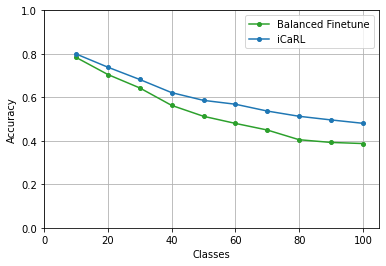

In [ ]:
import numpy as np
runBF = np.array([0.784,	0.705,	0.6433,	0.563,	0.5128,	0.4801,	0.4497,	0.405,	0.3926, 0.3875])

run1c = np.array([0.812,	0.7385,	0.6893,	0.62025,	0.582,	0.5628,	0.538,	0.5166,	0.4948, 0.4862])
run2c = np.array([0.754, 0.7185, 0.662, 0.608, 0.5796, 0.5598, 0.5278, 0.5005, 0.4985, 0.4707])
run3c = np.array([0.833, 0.759, 0.695, 0.6367, 0.5966, 0.5823, 0.545, 0.52125, 0.495, 0.4847])
iCaRL = np.array([run1c, run2c, run3c])
meaniCaRL = np.mean(iCaRL, axis = 0)
stdiCaRL = np.std(iCaRL, axis = 0)

import matplotlib.pyplot as plt
x = np.linspace(10,100, num = 10)
plt.show()
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.grid()
plt.errorbar(x, runBF, linestyle="-", marker = 'o', markersize = 4, ecolor='k', color = 'tab:green')
plt.errorbar(x, meaniCaRL, linestyle="-", marker = 'o', markersize = 4, ecolor='k', color = 'tab:blue')
plt.axis([0, 105, 0, 1])
plt.legend(['Balanced Finetune', 'iCaRL'])
#plt.show()
plt.savefig("variation.pdf")

In [40]:
distances = [[2,3],[3,6]]
distancesNp = np.array(distances)

9